# Airbus Impact Project

## Table of contents

1. [Imports](#1-imports)
    - [Import Datasets](#10-import-datasets)
2. [EDA](#define-date-and-time-columns)
3. [New Features](#new-features)

___
## 1. Imports

In [61]:
# Imports
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
from numpy import quantile, where, random
import datetime
import plotly.express as px
import plotly.graph_objs as go
from matplotlib import pyplot as plt, dates
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### 1.0 Import Datasets

In [62]:
filenames = ["data/msn_02_fuel_leak_signals_preprocessed.csv", 
             "data/msn_10_fuel_leak_signals_preprocessed.csv", 
             "data/msn_11_fuel_leak_signals_preprocessed.csv", 
             "data/msn_12_fuel_leak_signals_preprocessed.csv", 
             "data/msn_14_fuel_leak_signals_preprocessed.csv", 
             "data/msn_29_fuel_leak_signals_preprocessed.csv", 
             "data/msn_37_fuel_leak_signals_preprocessed.csv", 
             "data/msn_53_fuel_leak_signals_preprocessed.csv"]

datasets = []
datasets_labels = ["MSN_02", "MSN_10", "MSN_11", "MSN_12", "MSN_14", "MSN_29", "MSN_37", "MSN_53", "MSN_37_LEAK0.5", "MSN_37_LEAK1.0", "MSN_37_LEAK5.0"]
                   
for filename in filenames:
    datasets.append(pd.read_csv(filename, sep=";"))
    
# Copy datasets for leak simulation and add to datasets list
for i in range(3):
    datasets.append(datasets[6].copy())
    
print("Datasets loaded")

Datasets loaded


### 1.1 Define Date and Time Columns

In [63]:
for dataset in datasets:
    #introduce column date
    dataset['UTC_TIME'] = pd.to_datetime(dataset['UTC_TIME'])
    dataset['DATE'] = dataset['UTC_TIME'].dt.date
    dataset["TIME"] = dataset['UTC_TIME'].dt.time

___
## 2. Data Exploration

### 2.0 Check for Records and Features for every dataset

In [64]:
data = {}

data['Records'] = [dataset.shape[0] for dataset in datasets]
data['Features'] = [dataset.shape[1] for dataset in datasets]

pd.DataFrame(data, index = datasets_labels)

Records  Features
MSN_02           623580       113
MSN_10           621610        19
MSN_11          4455992        19
MSN_12          3247664        19
MSN_14          4640993        19
MSN_29          4129447        19
MSN_37          3236645        19
MSN_53          3034227        19
MSN_37_LEAK0.5  3236645        19
MSN_37_LEAK1.0  3236645        19
MSN_37_LEAK5.0  3236645        19

### 2.1 Display columns in all datasets

In [65]:
for dataset in datasets:
    print(dataset.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623580 entries, 0 to 623579
Data columns (total 113 columns):
 #    Column                                Dtype         
---   ------                                -----         
 0    UTC_TIME                              datetime64[ns]
 1    MSN                                   object        
 2    Flight                                object        
 3    ENGINE_RUNNING_1                      bool          
 4    ENGINE_RUNNING_2                      bool          
 5    ENGINE_RUNNING_3                      bool          
 6    ENGINE_RUNNING_4                      bool          
 7    FLIGHT_PHASE_COUNT                    float64       
 8    FUEL_FLOW_1                           float64       
 9    FUEL_FLOW_2                           float64       
 10   FUEL_FLOW_3                           float64       
 11   FUEL_FLOW_4                           float64       
 12   FUEL_PITCH                            float64       
 13

Print Total Null values and relative Null values

In [66]:
pd.DataFrame({'NULL_VALUES': datasets[0].isnull().sum(), 'NULL_VALUES_%': datasets[0].isnull().sum() / datasets[0].shape[0] * 100, 'UNIQUE VALUES': datasets[0].nunique()})

NULL_VALUES  NULL_VALUES_%  UNIQUE VALUES
UTC_TIME                       0       0.000000         610106
MSN                            0       0.000000              1
Flight                         0       0.000000             42
ENGINE_RUNNING_1               0       0.000000              2
ENGINE_RUNNING_2               0       0.000000              2
...                          ...            ...            ...
STATUS_OVERFLOW_RST        63293      10.149941              1
VALUE_FUEL_VOL_LST         63265      10.145450         231657
VALUE_FUEL_VOL_RST         63275      10.147054           1636
DATE                           0       0.000000             36
TIME                           0       0.000000          66578

[113 rows x 3 columns]

In [67]:
# Do the same for all datasets
df_feat = pd.DataFrame()

for i in range(1, len(datasets)):
    df_tmp = pd.DataFrame({f'{datasets_labels[i]}_miss': datasets[i].isnull().sum(), 
                           f'{datasets_labels[i]}_miss_%': datasets[i].isnull().sum() / datasets[i].shape[0] * 100, 
                           f'{datasets_labels[i]}_unique': datasets[i].nunique()})
    df_feat = pd.concat([df_feat, df_tmp], axis=1)
    
df_feat

MSN_10_miss  MSN_10_miss_%  MSN_10_unique  MSN_11_miss  \
UTC_TIME                      0       0.000000         621610            0   
FUEL_USED_2              562272      90.454143            167      4131081   
FUEL_USED_3              560674      90.197069             46      4139824   
FUEL_USED_4              565835      91.027332            280      4164851   
FW_GEO_ALTITUDE           82937      13.342289          34301       300327   
VALUE_FOB                 82937      13.342289          40071       300327   
VALUE_FUEL_QTY_CT         82937      13.342289          10980       300327   
VALUE_FUEL_QTY_FT1        82937      13.342289           1007       300327   
VALUE_FUEL_QTY_FT2        82937      13.342289           1366       300327   
VALUE_FUEL_QTY_FT3        82937      13.342289           1162       300327   
VALUE_FUEL_QTY_FT4        82937      13.342289            994       300327   
VALUE_FUEL_QTY_LXT        82937      13.342289          12884       300327   
VALUE_FUEL_QTY_RXT        82937      13.342289          12803       300327   
FLIGHT_PHASE_COUNT        82364      13.250109             13       300201   
FUEL_USED_1              569171      91.564003             44      4126336   
Flight                        0       0.000000            540            0   
MSN                           0       0.000000              1            0   
DATE                          0       0.000000            114            0   
TIME                          0       0.000000          86400            0   

                    MSN_11_miss_%  MSN_11_unique  MSN_12_miss  MSN_12_miss_%  \
UTC_TIME                 0.000000        4455992            0       0.000000   
FUEL_USED_2             92.708447          79193      3123512      96.177191   
FUEL_USED_3             92.904655          74411      3124135      96.196374   
FUEL_USED_4             93.466303          61768      3124839      96.218051   
FW_GEO_ALTITUDE          6.739846          36757        40360       1.242739   
VALUE_FOB                6.739846          51763        40170       1.236889   
VALUE_FUEL_QTY_CT        6.739846          11490        40170       1.236889   
VALUE_FUEL_QTY_FT1       6.739846           1805        40170       1.236889   
VALUE_FUEL_QTY_FT2       6.739846           2238        40170       1.236889   
VALUE_FUEL_QTY_FT3       6.739846           2201        40170       1.236889   
VALUE_FUEL_QTY_FT4       6.739846           1954        40170       1.236889   
VALUE_FUEL_QTY_LXT       6.739846          13565        40170       1.236889   
VALUE_FUEL_QTY_RXT       6.739846          13431        40170       1.236889   
FLIGHT_PHASE_COUNT       6.737018             13        39807       1.225712   
FUEL_USED_1             92.601962          84070      3118944      96.036536   
Flight                   0.000000           2024            0       0.000000   
MSN                      0.000000              1            0       0.000000   
DATE                     0.000000            527            0       0.000000   
TIME                     0.000000          86400            0       0.000000   

                    MSN_12_unique  MSN_14_miss  MSN_14_miss_%  MSN_14_unique  \
UTC_TIME                  3247664            0       0.000000        4640993   
FUEL_USED_2                 76080      4372059      94.205249         183458   
FUEL_USED_3                 73428      4371649      94.196414         175370   
FUEL_USED_4                 67163      4374096      94.249140         160715   
FW_GEO_ALTITUDE             36710        65487       1.411056          36845   
VALUE_FOB                   43076        65487       1.411056          43874   
VALUE_FUEL_QTY_CT           11305        65487       1.411056          11550   
VALUE_FUEL_QTY_FT1           1425        65487       1.411056           1566   
VALUE_FUEL_QTY_FT2           1877        65487       1.411056           2266   
VALUE_FUEL_QTY_FT3           1939        65487       1.411

In [68]:
# print relative amount of flight phase 8
print("Relative amount of flight phases 3-11")
for dataset in datasets:
    print(dataset[dataset['FLIGHT_PHASE_COUNT'].isin(list(range(3,12)))].shape[0] / dataset.shape[0] * 100)
    
print("\nRelative amount of rows with NaN values in flight phases 3-11")
# count rows with NaN values in flight phases 3-11
for dataset in datasets:
    print(dataset[dataset['FLIGHT_PHASE_COUNT'].isin(list(range(3,12)))].isnull().any(axis=1).sum() / dataset.shape[0] * 100)


Relative amount of flight phases 3-11
70.66102184162418
76.78930519135793
83.32833631658225
87.78793003217082
88.45331160809766
82.0043458603537
87.88680871705114
88.84331989663265
87.88680871705114
87.88680871705114
87.88680871705114

Relative amount of rows with NaN values in flight phases 3-11
69.13691908015011
76.78930519135793
82.6928100409516
86.52459121386941
85.92697726542575
81.70161767423096
84.53345980173914
85.43022654534417
84.53345980173914
84.53345980173914
84.53345980173914


In [69]:
records_total = sum([dataset.shape[0] for dataset in datasets])
records_dropna = sum([dataset.dropna().shape[0] for dataset in datasets])

records_dropna_flightphase = {
    i: sum([dataset[dataset['FLIGHT_PHASE_COUNT'] == i].dropna().shape[0] for dataset in datasets])
    for i in range(1, 13)
}

print("Total records:", records_total)
print("Records after dropna:", records_dropna)
print("Records after dropna per flight phase:", records_dropna_flightphase)

Total records: 33700093
Records after dropna: 1664035
Records after dropna per flight phase: {1: 16973, 2: 897470, 3: 678, 4: 169, 5: 312, 6: 727, 7: 6479, 8: 670745, 9: 2677, 10: 241, 11: 64277, 12: 3287}


In [70]:
# Drop rows with duplicats in UTC_TIME
for dataset in datasets:
    dataset.drop_duplicates(subset=['UTC_TIME'], inplace=True)

In [71]:
df_tmp = pd.DataFrame(records_dropna_flightphase, index=['Records']).transpose()
 
fig = px.bar(df_tmp, x=df_tmp.index, y='Records', title='Records after dropna per flight phase')
fig.show()


### Calculate std of diff in tanks by flight-phase.

In [72]:
datasets_dropna = [df.dropna() for df in datasets]
all_datasets = pd.concat(datasets_dropna, ignore_index=True)

columns_to_describe = [
    'FUEL_USED_1', 
    'FUEL_USED_2', 
    'FUEL_USED_3', 
    'FUEL_USED_4', 
    'VALUE_FUEL_QTY_CT', 
    'VALUE_FUEL_QTY_RXT', 
    'VALUE_FUEL_QTY_LXT', 
    'VALUE_FUEL_QTY_FT1', 
    'VALUE_FUEL_QTY_FT2', 
    'VALUE_FUEL_QTY_FT3', 
    'VALUE_FUEL_QTY_FT4'
]

all_datasets_diff = all_datasets.groupby('FLIGHT_PHASE_COUNT')[columns_to_describe].diff().dropna()
std_df = all_datasets_diff[columns_to_describe].std().reset_index()
std_df

index           0
0          FUEL_USED_1  222.717422
1          FUEL_USED_2  221.589062
2          FUEL_USED_3  222.783578
3          FUEL_USED_4  223.892546
4    VALUE_FUEL_QTY_CT  201.931968
5   VALUE_FUEL_QTY_RXT  282.835625
6   VALUE_FUEL_QTY_LXT  284.436186
7   VALUE_FUEL_QTY_FT1   17.931267
8   VALUE_FUEL_QTY_FT2   23.882145
9   VALUE_FUEL_QTY_FT3   24.819852
10  VALUE_FUEL_QTY_FT4   19.429669

As can be seen in the examples above, flight phases two and eight are the ones that contain the most data. The fact that flight phase two describes the aircraft on the ground and that the parameters there could be falsified, for example, by refuelling or artificially resetting the fuel consumption, and the requirements of Airbus have prompted us to adopt only flight phase eight in our model.

___
# 3. Data Cleaning and Feature Engineering


### 3.0 Assign to each concetenated flight a unique flight number and only keep flight_phases 8

In the next cell we will divide the data into individual flight segments, which will be assigned unique numbers. This has the advantage that we can analyse individual sequences and describe them further in the EDA process. Before and after this, zero values are dropped.

We're keeping flight phases 2 and 8 as they have a lot of values that could be used for anomaly detection. 

We're cleaning the second flight_phase.

In [73]:
columns_where_to_drop_nan = datasets[2].columns

def introduce_flight_column(dataset):
    # copy dataset
    dataset_tmp = dataset.copy()
    
    # Drop NaN values
    dataset_tmp = dataset_tmp.dropna(subset=columns_where_to_drop_nan)
    
    # Variable to store flight number
    flight_number = 0
    
    # assign flight number to rows that have indexes following each other
    # if the difference between two indexes is greater than 1, a new flight is assumed
    # print(dataset_tmp.shape)
    
    for i in range(1, dataset_tmp.shape[0]):
        if dataset_tmp.index[i] - dataset_tmp.index[i-1] > 1:
            flight_number += 1
        dataset_tmp.at[dataset_tmp.index[i], 'FLIGHT'] = flight_number
        
    # Fill nan values in flight column with 0
    dataset_tmp['FLIGHT'] = dataset_tmp['FLIGHT'].fillna(0)
    
    # only keep rows with flight_phase_count = 2 and 8
    dataset_tmp =  dataset_tmp[dataset_tmp['FLIGHT_PHASE_COUNT'].isin([2, 8])]
            
    # return dataset with flight column
    return dataset_tmp
   

In [74]:
datasets_unique_flights = [introduce_flight_column(dataset) for dataset in datasets_dropna]

In [75]:
for dataset in datasets_unique_flights:
    print(dataset.shape)

(15988, 114)
(24, 20)
(90529, 20)
(86258, 20)
(196207, 20)
(48111, 20)
(229909, 20)
(210181, 20)
(229909, 20)
(229909, 20)
(229909, 20)


### 3.0 Add synthetic Fuel Leak to different datasets

In [76]:
def create_leak(dataset, leak_flow):
    # create copy of dataset    
    dataset_tmp = dataset.copy()
    
    # define FUEL_TANK_COLS 
    FUEL_TANK_COLS = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']
    
    # leak flow in L/sec
    leak_flow = leak_flow / 60
    
    # substract leak flow from VALUE_FOB 
    dataset_tmp['VALUE_FOB'] = dataset_tmp['VALUE_FOB'] - leak_flow

    print('Before Tank chosen')

    # choose random fuel tank where the fuel leak is happening
    while True:
        fuel_tank = random.choice(FUEL_TANK_COLS)
     
        # check if fuel tank is empty at any point in time
        if dataset_tmp[fuel_tank].max() >= leak_flow:
            break
            
    print('Fuel Tank chosen')
            
    # substract leak flow from fuel tank
    dataset_tmp[fuel_tank] = dataset_tmp[fuel_tank] - leak_flow
    
    # set negative values in value_fob and fuel_tank to 0
    dataset_tmp['VALUE_FOB'] = dataset_tmp['VALUE_FOB'].clip(lower=0)

    
    return dataset_tmp

In [77]:
# from this point the following changes will be applied to two list of datasets
datasets_unique_flights_with_fuel_leak = datasets_unique_flights.copy()

# add fuel leak to the last 3 datasets. First one 0.5L per minute, second 1L per minute, third 5L per minute
datasets_unique_flights_with_fuel_leak[-1] = create_leak(datasets_unique_flights[-1], 5)
datasets_unique_flights_with_fuel_leak[-2] = create_leak(datasets_unique_flights[-2], 1)
datasets_unique_flights_with_fuel_leak[-3] = create_leak(datasets_unique_flights[-3], 0.5)

Before Tank chosen
Fuel Tank chosen
Before Tank chosen
Fuel Tank chosen
Before Tank chosen
Fuel Tank chosen


In [78]:
for dataset in datasets_unique_flights:
    print(dataset.shape)

(15988, 114)
(24, 20)
(90529, 20)
(86258, 20)
(196207, 20)
(48111, 20)
(229909, 20)
(210181, 20)
(229909, 20)
(229909, 20)
(229909, 20)


As we don't have a single value in Dataset 2 we gonna drop it at this point

In [79]:
# Drop second dataset from datasets_unique_flights
#datasets_unique_flights.pop(1)
#datasets_unique_flights_with_fuel_leak.pop(1)

### 3.2 New Features

In [80]:
# helper function to subtract first value of a series from all values
def subtract_first(x):
    return x.iloc[0] - x

def define_new_features(dataset):
    # copy dataset
    dataset_tmp = dataset.copy()
    
    # initialize TOTAL_FUEK_USED column
    dataset_tmp['TOTAL_FUEL_USED'] = 0
     
    # Total fuel column is the sum of all fuel used columns
    for i in range(1, 5):
        dataset_tmp['TOTAL_FUEL_USED'] += dataset_tmp['FUEL_USED_' + str(i)]
        
    # Get difference for VALUE_FOB. For each flight the first value must be 0
    dataset_tmp['VALUE_FOB_DIFF'] = dataset_tmp.groupby('FLIGHT')['VALUE_FOB'].diff()
    dataset_tmp['VALUE_FOB_DIFF'] = dataset_tmp['VALUE_FOB_DIFF'].fillna(0)
    
    dataset_tmp['TOTAL_FOB_BY_QTY'] = dataset_tmp['VALUE_FUEL_QTY_CT'] + dataset_tmp['VALUE_FUEL_QTY_FT1'] + dataset_tmp['VALUE_FUEL_QTY_FT2'] + dataset_tmp['VALUE_FUEL_QTY_FT3'] + dataset_tmp['VALUE_FUEL_QTY_FT4'] + dataset_tmp['VALUE_FUEL_QTY_LXT'] + dataset_tmp['VALUE_FUEL_QTY_RXT']
    
    dataset_tmp['DELTA_VFOB_VS_VFOBQTY'] = dataset_tmp['VALUE_FOB'] - dataset_tmp['TOTAL_FOB_BY_QTY']
    
    dataset_tmp['ALTITUDE_DIFF'] = dataset_tmp['FW_GEO_ALTITUDE'].diff().abs() 
    
    dataset_tmp['VALUE_FOB_MISSING'] = dataset.groupby('FLIGHT')['VALUE_FOB'].transform(subtract_first)  
    
    # code to remove first part of flight where the plane is on the ground and the fuel used is resetted
    for flight_num in dataset_tmp['FLIGHT'].unique():
        # get first index of flight 
        first_index = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num].index[0]
        
        # get last index of flight
        last_index = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num].index[-1]
        
        # get location of min value of VALUE_FOB per flight 
        min_value_sum_fuel_used = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num]['TOTAL_FUEL_USED'].idxmin()
        
        # delete in dataset_tmp all rows between first_location and min_value_fob
        dataset_tmp.drop(dataset_tmp.loc[first_index:min_value_sum_fuel_used].index, inplace=True) 
    
    # for each FLIGHT substract the first value of TOTAL_FUEL_USED from all values
    #for flight in dataset_tmp['FLIGHT'].unique():
    #    dataset_tmp.loc[dataset_tmp['FLIGHT'] == flight, 'TOTAL_FUEL_USED'] -= dataset_tmp[dataset_tmp['FLIGHT'] == flight]['TOTAL_FUEL_USED'].iloc[0]
    
    return dataset_tmp

In [81]:
datasets_with_new_features = [define_new_features(dataset) for dataset in datasets_unique_flights]
datasets_with_new_features_with_fuel_leak = [define_new_features(dataset) for dataset in datasets_unique_flights_with_fuel_leak]

In [82]:
# Print shape of datasets to see total number of features
for dataset in datasets_with_new_features:
    print(dataset.shape)

(15239, 120)
(23, 26)
(59662, 26)
(64349, 26)
(155946, 26)
(30020, 26)
(164605, 26)
(151035, 26)
(164605, 26)
(164605, 26)
(164605, 26)


### 3.3 Deleting Values before all Fuel_Used Columns are resetted 
Not necassary if only flight phase 8 is used

In [83]:
def initalize_flights(dataset):
    # copy dataset
    dataset_tmp = dataset.copy()
     
    for flight_num in dataset_tmp['FLIGHT'].unique():
        # get first index of flight 
        first_index = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num].index[0]
        
        # get last index of flight
        last_index = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num].index[-1]
        
        # get location of min value of VALUE_FOB per flight 
        min_value_sum_fuel_used = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num]['TOTAL_FUEL_USED'].idxmin()
        
        # delete in dataset_tmp all rows between first_location and min_value_fob
        dataset_tmp.drop(dataset_tmp.loc[first_index:min_value_sum_fuel_used].index, inplace=True)
        
        # dataset_tmp["VALUE_FOB_MISSING"] = dataset_tmp.groupby('FLIGHT')['VALUE_FOB'].transform(subtract_first)
        
    return dataset_tmp

In [84]:
# Not necassary if only flight phase 8 is used
# datasets_without_reset_engines = [initalize_flights(dataset) for dataset in datasets_with_new_features]

In [85]:
for i, dataset in enumerate(datasets_with_new_features):
    print(f'Dataset {i} shape: {dataset.shape}')
    print(f'Dataset {i} unique flights: {dataset["FLIGHT"].nunique()}')

Dataset 0 shape: (15239, 120)
Dataset 0 unique flights: 19
Dataset 1 shape: (23, 26)
Dataset 1 unique flights: 1
Dataset 2 shape: (59662, 26)
Dataset 2 unique flights: 403
Dataset 3 shape: (64349, 26)
Dataset 3 unique flights: 360
Dataset 4 shape: (155946, 26)
Dataset 4 unique flights: 809
Dataset 5 shape: (30020, 26)
Dataset 5 unique flights: 203
Dataset 6 shape: (164605, 26)
Dataset 6 unique flights: 978
Dataset 7 shape: (151035, 26)
Dataset 7 unique flights: 886
Dataset 8 shape: (164605, 26)
Dataset 8 unique flights: 978
Dataset 9 shape: (164605, 26)
Dataset 9 unique flights: 978
Dataset 10 shape: (164605, 26)
Dataset 10 unique flights: 978


Plot Altitude vs Value Fob for dataset 0

Plot Altitude vs Value Fob for the rest of the datasets

In [86]:
flight_phase_dict = {
    1: 'Pre-flight',
    2: 'Engine Run',
    3: 'Take-Off 1',
    4: 'Take-Off 2',
    5: 'Take-Off 3',
    6: 'Climbing 1',
    7: 'Climbing 2',
    8: 'Cruise',
    9: 'Descent',
    10: 'Approach',
    11: 'Landing',
    12: 'Post-flight'
}

def plot_flight(dataset, min_flight_length=100, max_graphs=10):
    for flight_num in dataset["FLIGHT"].unique(): 
        fig = go.Figure()

        # Define data for flight
        flight_data = dataset[dataset['FLIGHT'] == flight_num]
        
        if flight_data.shape[0] < min_flight_length:
            continue
        
        # Define traces
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                y=flight_data['VALUE_FOB'],
                                mode='lines',
                                name='VALUE_FOB')) 

        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                y=flight_data['FW_GEO_ALTITUDE'],
                                mode='lines',
                                name='FW_GEO_ALTITUDE'))
        
        # add trace for total_fuel_used
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                    y=flight_data['TOTAL_FUEL_USED'],
                                    mode='lines',
                                    name='TOTAL_FUEL_USED'))
        
        # add trace for VALUE_FOB_DIFF
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                    y=flight_data['VALUE_FOB_DIFF'],
                                    mode='lines',
                                    name='VALUE_FOB_DIFF'))
        
        
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                    y=flight_data['VALUE_FOB_MISSING'],
                                    mode='lines',
                                    name='VALUE_FOB_MISSING'))
        
        
        for flight_phase in flight_data['FLIGHT_PHASE_COUNT'].unique():
            fig.add_trace(go.Scatter(x=flight_data[flight_data['FLIGHT_PHASE_COUNT'] == flight_phase]['UTC_TIME'],
                                    y=flight_data[flight_data['FLIGHT_PHASE_COUNT'] == flight_phase]['VALUE_FOB'],
                                    mode='lines',
                                        name=f'{flight_phase}, {flight_phase_dict[flight_phase]}'))

        fig.update_layout(title=f'VALUE_FOB and FW_GEO_ALTITUDE for flight {flight_num}',
                        xaxis_title='UTC_TIME',
                        yaxis_title='VALUE_FOB and FW_GEO_ALTITUDE')
        
        # Define rectangles for different flight phases
        shapes = []
        colors = [
        'LightSkyBlue', 'LightSalmon', 'LightGreen', 'LightYellow', 'LightPink', 
        'MediumPurple', 'DarkOrange', 'MediumSeaGreen', 'DeepSkyBlue']
        # Define more colors if needed
        for i, flight_phase in enumerate(flight_data['FLIGHT_PHASE_COUNT'].unique()):
            phase_data = flight_data[flight_data['FLIGHT_PHASE_COUNT'] == flight_phase]
            shapes.append(
                go.layout.Shape(
                    type="rect",
                    xref="x",
                    yref="paper",  # use 'paper' to refer to the entire y range
                    x0=phase_data['UTC_TIME'].min(),
                    x1=phase_data['UTC_TIME'].max(),
                    y0=0,
                    y1=1,
                    fillcolor=colors[i % len(colors)],
                    opacity=0.5,
                    layer="below",
                    line_width=0,
                )
            )
        
        fig.update_layout(shapes=shapes)
        fig.show()
        
        max_graphs -= 1
        
        if(max_graphs == 0):    
            break
        
        


In [87]:
plot_flight(datasets_with_new_features[-1], min_flight_length=500, max_graphs=3)

In [88]:
plot_flight(datasets_with_new_features_with_fuel_leak[-1], min_flight_length=500, max_graphs=3)

## Bring all datasets to the same shape

In [89]:
# Define functions to drop so that all datasets have the same columns
columns_to_drop = [column for column in datasets_with_new_features[0].columns if column not in datasets_with_new_features[2].columns]

datasets_with_new_features[0].drop(columns_to_drop, axis=1, inplace=True)
datasets_with_new_features_with_fuel_leak[0].drop(columns_to_drop, axis=1, inplace=True) 

In [90]:
# shape of datasets
for i, dataset in enumerate(datasets_with_new_features):
    print(f'Dataset {i} shape: {dataset.shape}')
    print(f'Dataset {i} unique flights: {dataset["FLIGHT"].nunique()}')

Dataset 0 shape: (15239, 26)
Dataset 0 unique flights: 19
Dataset 1 shape: (23, 26)
Dataset 1 unique flights: 1
Dataset 2 shape: (59662, 26)
Dataset 2 unique flights: 403
Dataset 3 shape: (64349, 26)
Dataset 3 unique flights: 360
Dataset 4 shape: (155946, 26)
Dataset 4 unique flights: 809
Dataset 5 shape: (30020, 26)
Dataset 5 unique flights: 203
Dataset 6 shape: (164605, 26)
Dataset 6 unique flights: 978
Dataset 7 shape: (151035, 26)
Dataset 7 unique flights: 886
Dataset 8 shape: (164605, 26)
Dataset 8 unique flights: 978
Dataset 9 shape: (164605, 26)
Dataset 9 unique flights: 978
Dataset 10 shape: (164605, 26)
Dataset 10 unique flights: 978


In [91]:
datasets_with_new_features[0]

UTC_TIME         MSN Flight  FLIGHT_PHASE_COUNT  \
33796  2016-10-07 07:38:15  A400M-0002  V0926                 2.0   
33797  2016-10-07 07:38:16  A400M-0002  V0926                 2.0   
33798  2016-10-07 07:38:17  A400M-0002  V0926                 2.0   
33799  2016-10-07 07:38:18  A400M-0002  V0926                 2.0   
33800  2016-10-07 07:38:19  A400M-0002  V0926                 2.0   
...                    ...         ...    ...                 ...   
589704 2016-10-07 12:16:19  A400M-0002  V0927                 8.0   
589705 2016-10-07 12:16:20  A400M-0002  V0927                 8.0   
589706 2016-10-07 12:16:21  A400M-0002  V0927                 8.0   
589707 2016-10-07 12:16:22  A400M-0002  V0927                 8.0   
589708 2016-10-07 12:16:23  A400M-0002  V0927                 8.0   

        FUEL_USED_1  FUEL_USED_2  FUEL_USED_3  FUEL_USED_4  FW_GEO_ALTITUDE  \
33796      6.417926     2.685516     0.002914       0.0000         539.1815   
33797      6.519280     2.784187     0.003221       0.0000         539.0031   
33798      6.620632     2.883186     0.003584       0.0000         539.0146   
33799      6.721996     2.982092     0.003665       0.0000         539.0156   
33800      6.823327     3.081056     0.003076       0.0000         539.0253   
...             ...          ...          ...          ...              ...   
589704   230.085300   224.718800   219.949800     219.0472        8940.9190   
589705   230.553500   225.181900   220.410700     219.5204        8971.0700   
589706   231.020300   225.645300   220.871400     219.9929        8998.1840   
589707   231.488400   226.107700   221.332000     220.5084        9028.9930   
589708   231.955400   226.571200   221.794000     220.9805        9060.7160   

        VALUE_FOB  VALUE_FUEL_QTY_CT  VALUE_FUEL_QTY_FT1  VALUE_FUEL_QTY_FT2  \
33796     17915.0                0.0              1949.0              2529.0   
33797     17914.0                0.0              1949.0              2529.0   
33798     17915.0                0.0              1949.0              2529.0   
33799     17915.0                0.0              1948.0              2528.0   
33800     17915.0                0.0              1948.0              2528.0   
...           ...                ...                 ...                 ...   
589704    19023.0                0.0              1775.0              2463.0   
589705    19020.0                0.0              1774.0              2461.0   
589706    19016.0                0.0              1773.0              2460.0   
589707    19012.0                0.0              1772.0              2460.0   
589708    19011.0                0.0              1772.0              2459.0   

        VALUE_FUEL_QTY_FT3  VALUE_FUEL_QTY_FT4  VALUE_FUEL_QTY_LXT  \
33796               2588.0              1929.0              4587.0   
33797               2588.0              1929.0              4586.0   
33798               2588.0              1929.0              4586.0   
33799               2588.0              1929.0              4586.0   
33800               2588.0              1929.0              4586.0   
...                    ...                 ...                 ...   
589704              2636.0              1758.0              5283.0   
589705              2636.0              1760.0              5283.0   
589706              2636.0              1762.0              5282.0   
589707              2635.0              1763.0              5281.0   
589708              2635.0              1765.0              5281.0   

        VALUE_FUEL_QTY_RXT        DATE      TIME  FLIGHT  TOTAL_FUEL_USED  \
33796               4335.0  2016-10-07  07:38:15     0.0         9.106356   
33797               4335.0  2016-10-07  07:38:16     0.0         9.306688   
33798               4336.0  2016-10-07  07:38:17     0.0         9.507402   
33799               4336.0  2016-10-07  07:38:18     0.0         9.707753   
33800               4337.0  2016-10-07  07:38:19     

Dataset 0 shape: (15239, 26)
Dataset 0 unique flights: 19


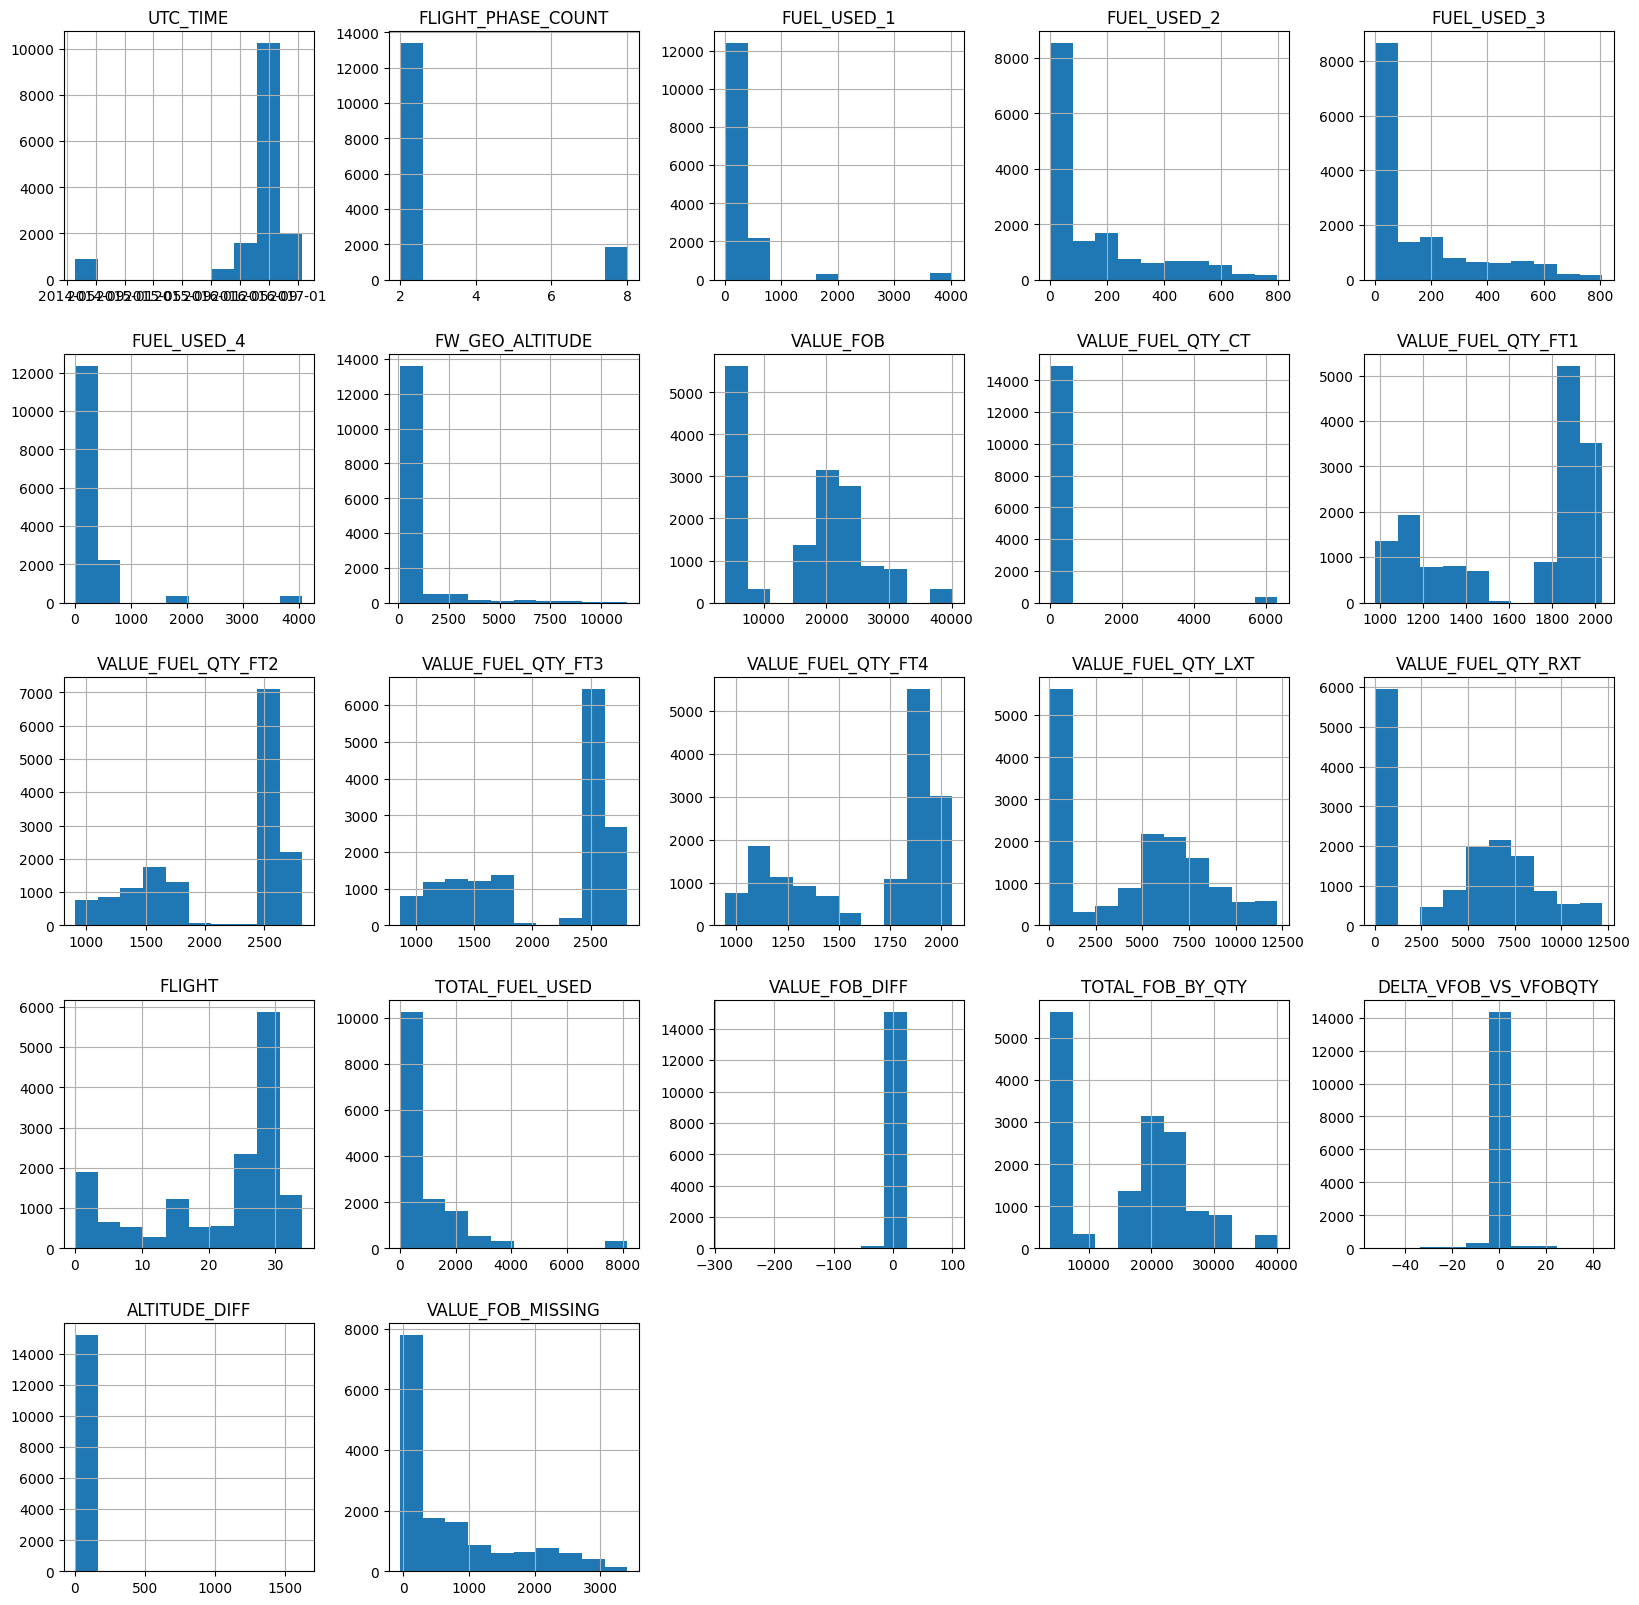

Dataset 1 shape: (23, 26)
Dataset 1 unique flights: 1


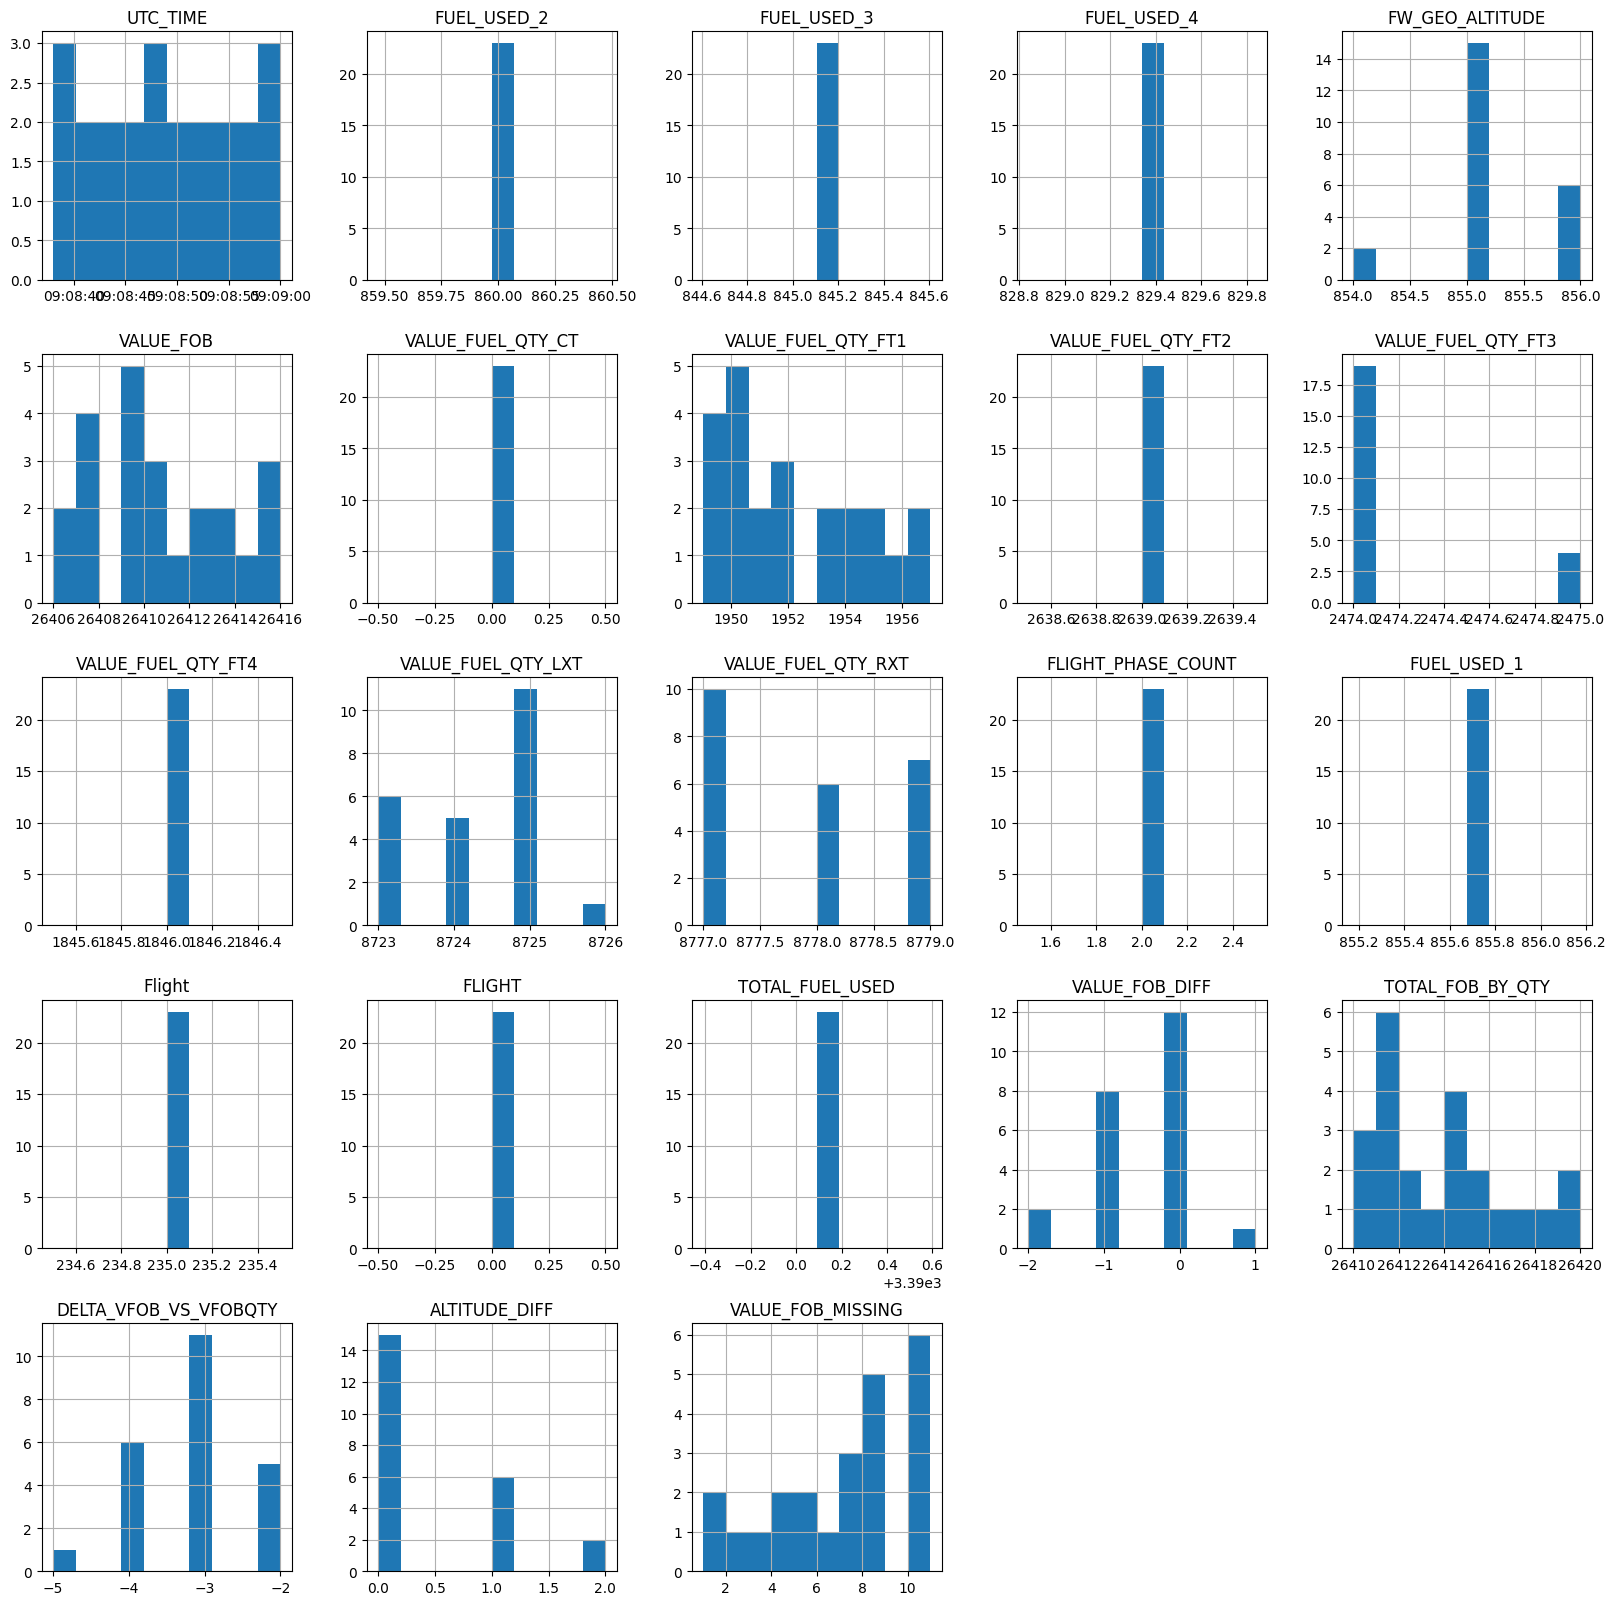

Dataset 2 shape: (59662, 26)
Dataset 2 unique flights: 403


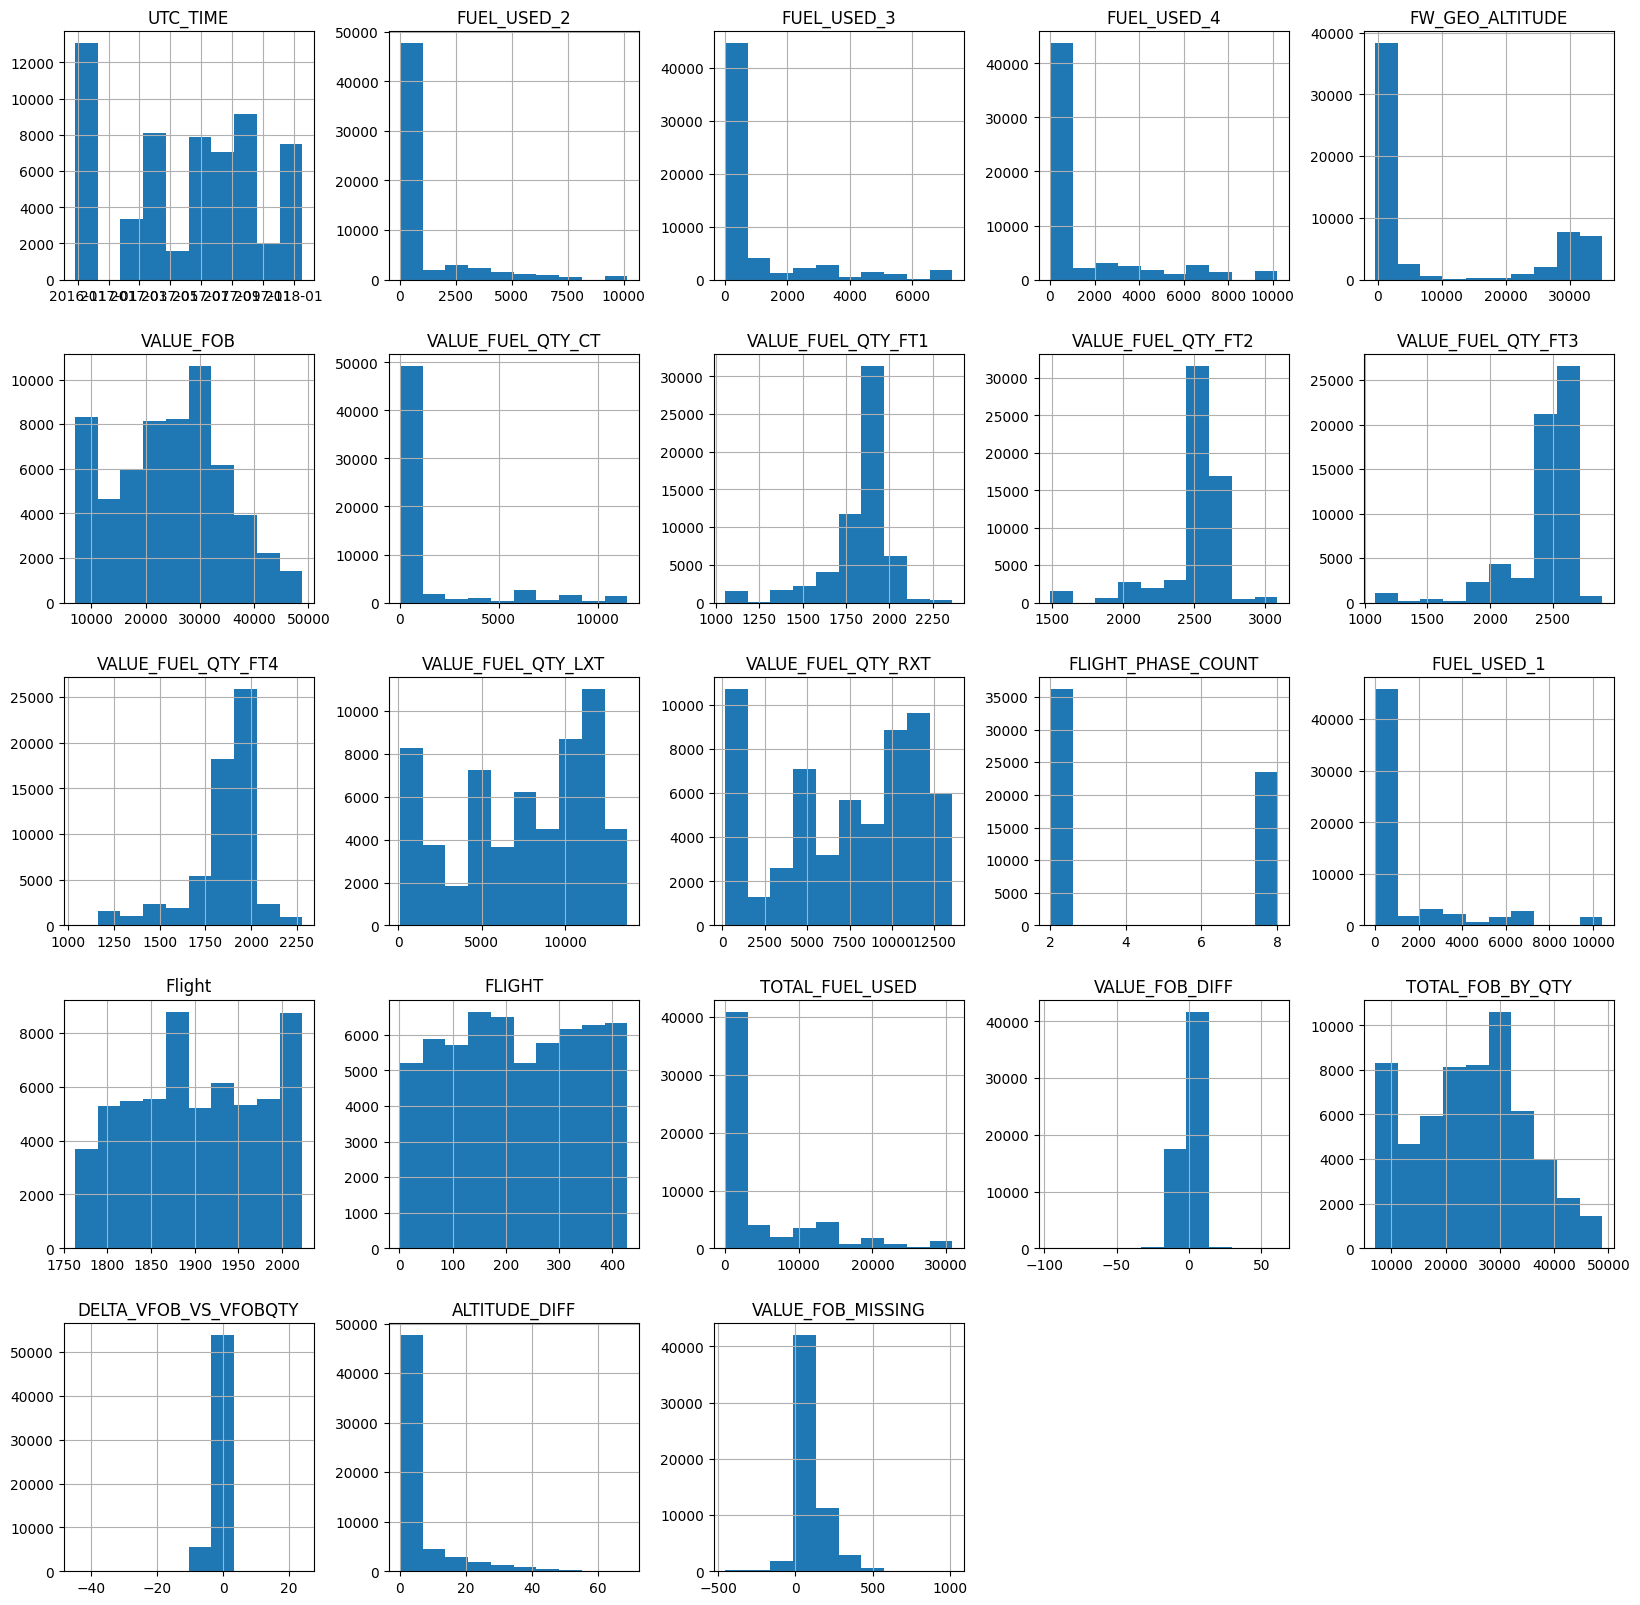

Dataset 3 shape: (64349, 26)
Dataset 3 unique flights: 360


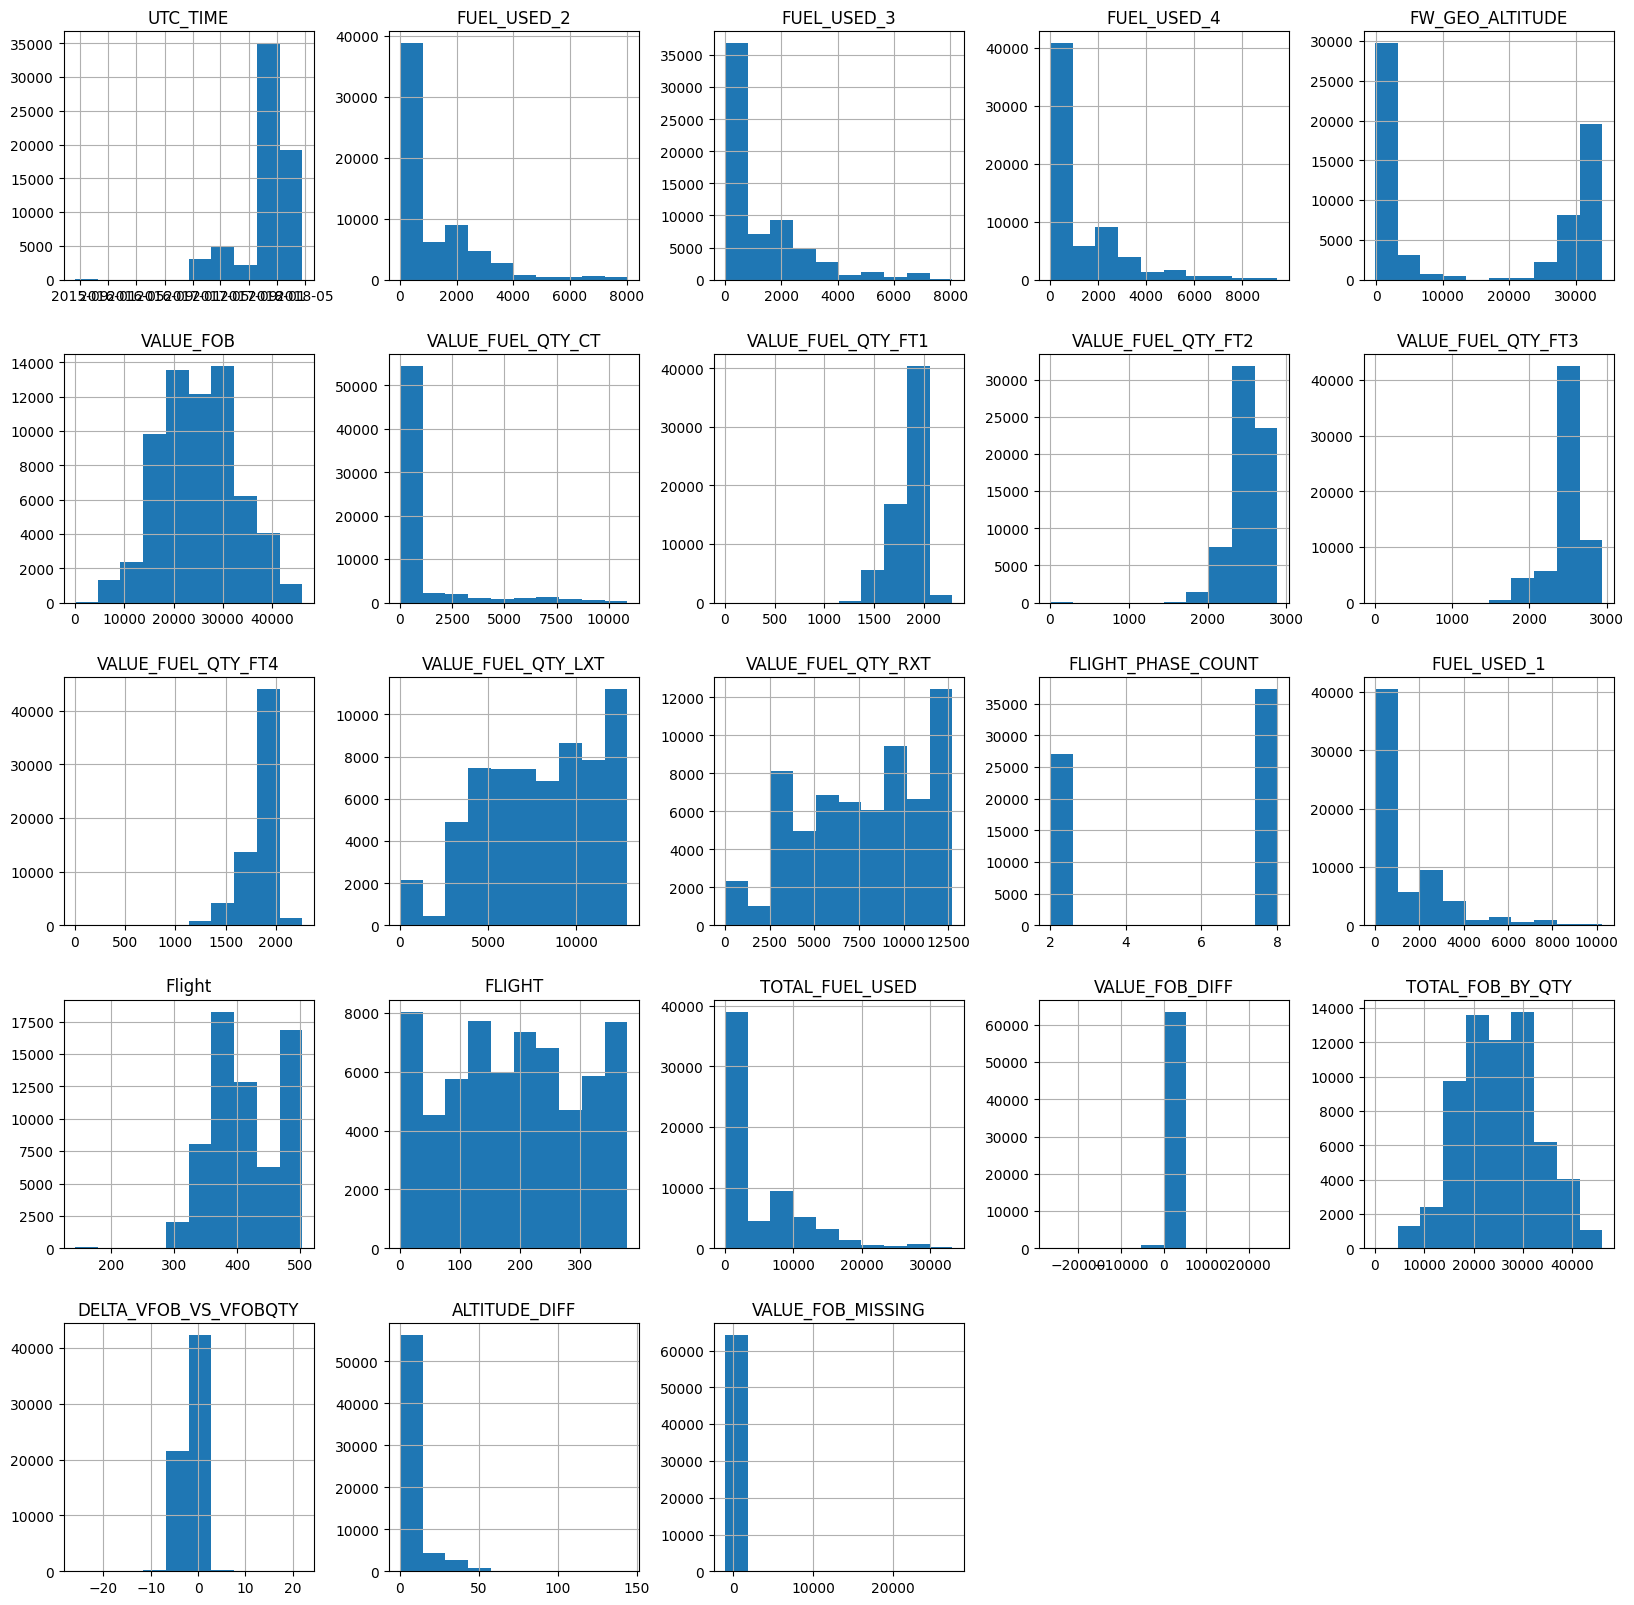

Dataset 4 shape: (155946, 26)
Dataset 4 unique flights: 809


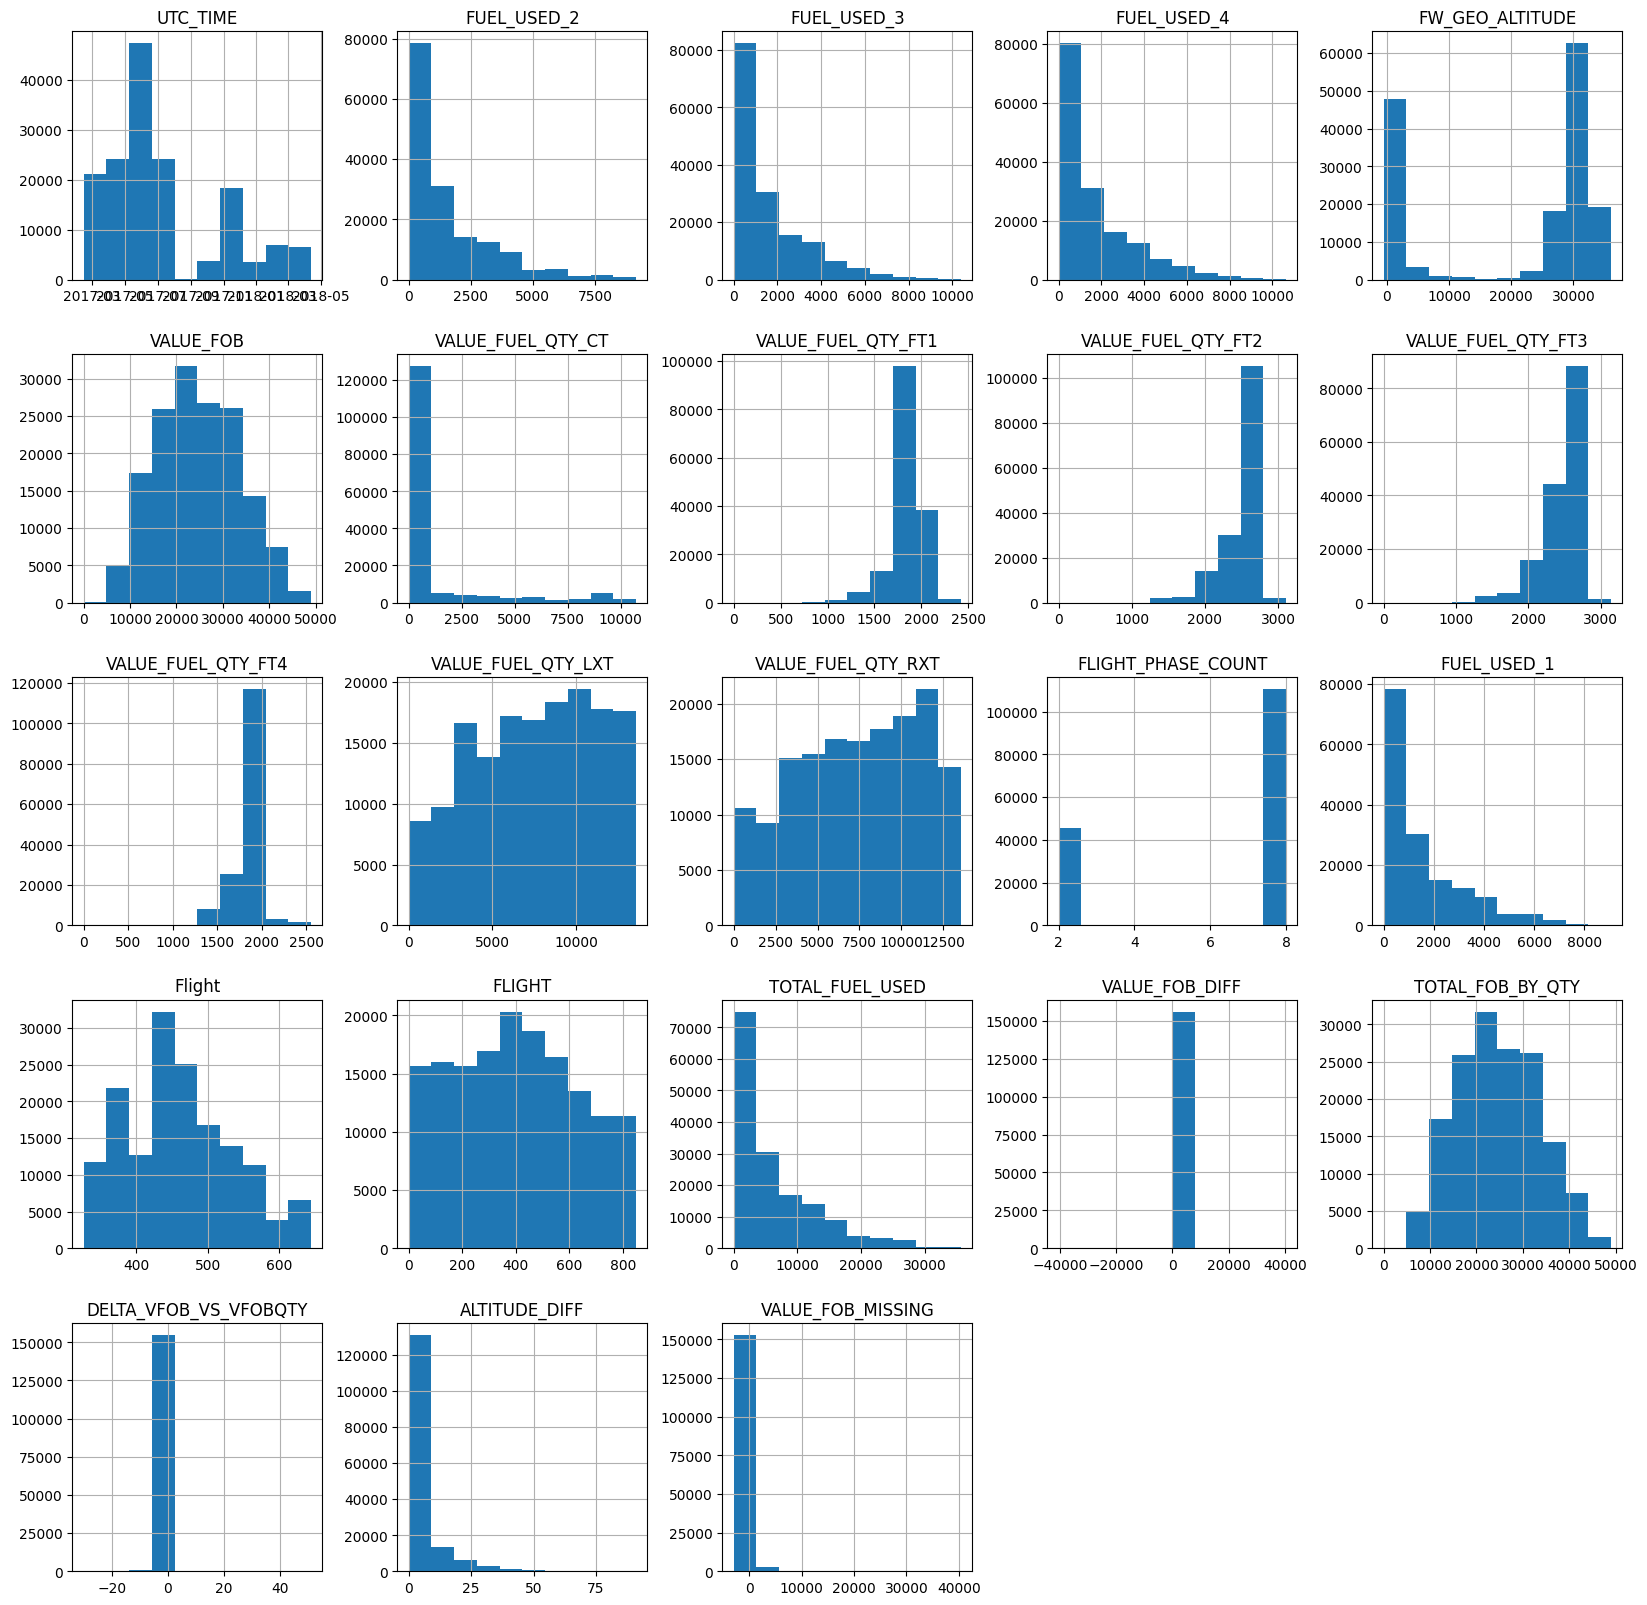

Dataset 5 shape: (30020, 26)
Dataset 5 unique flights: 203


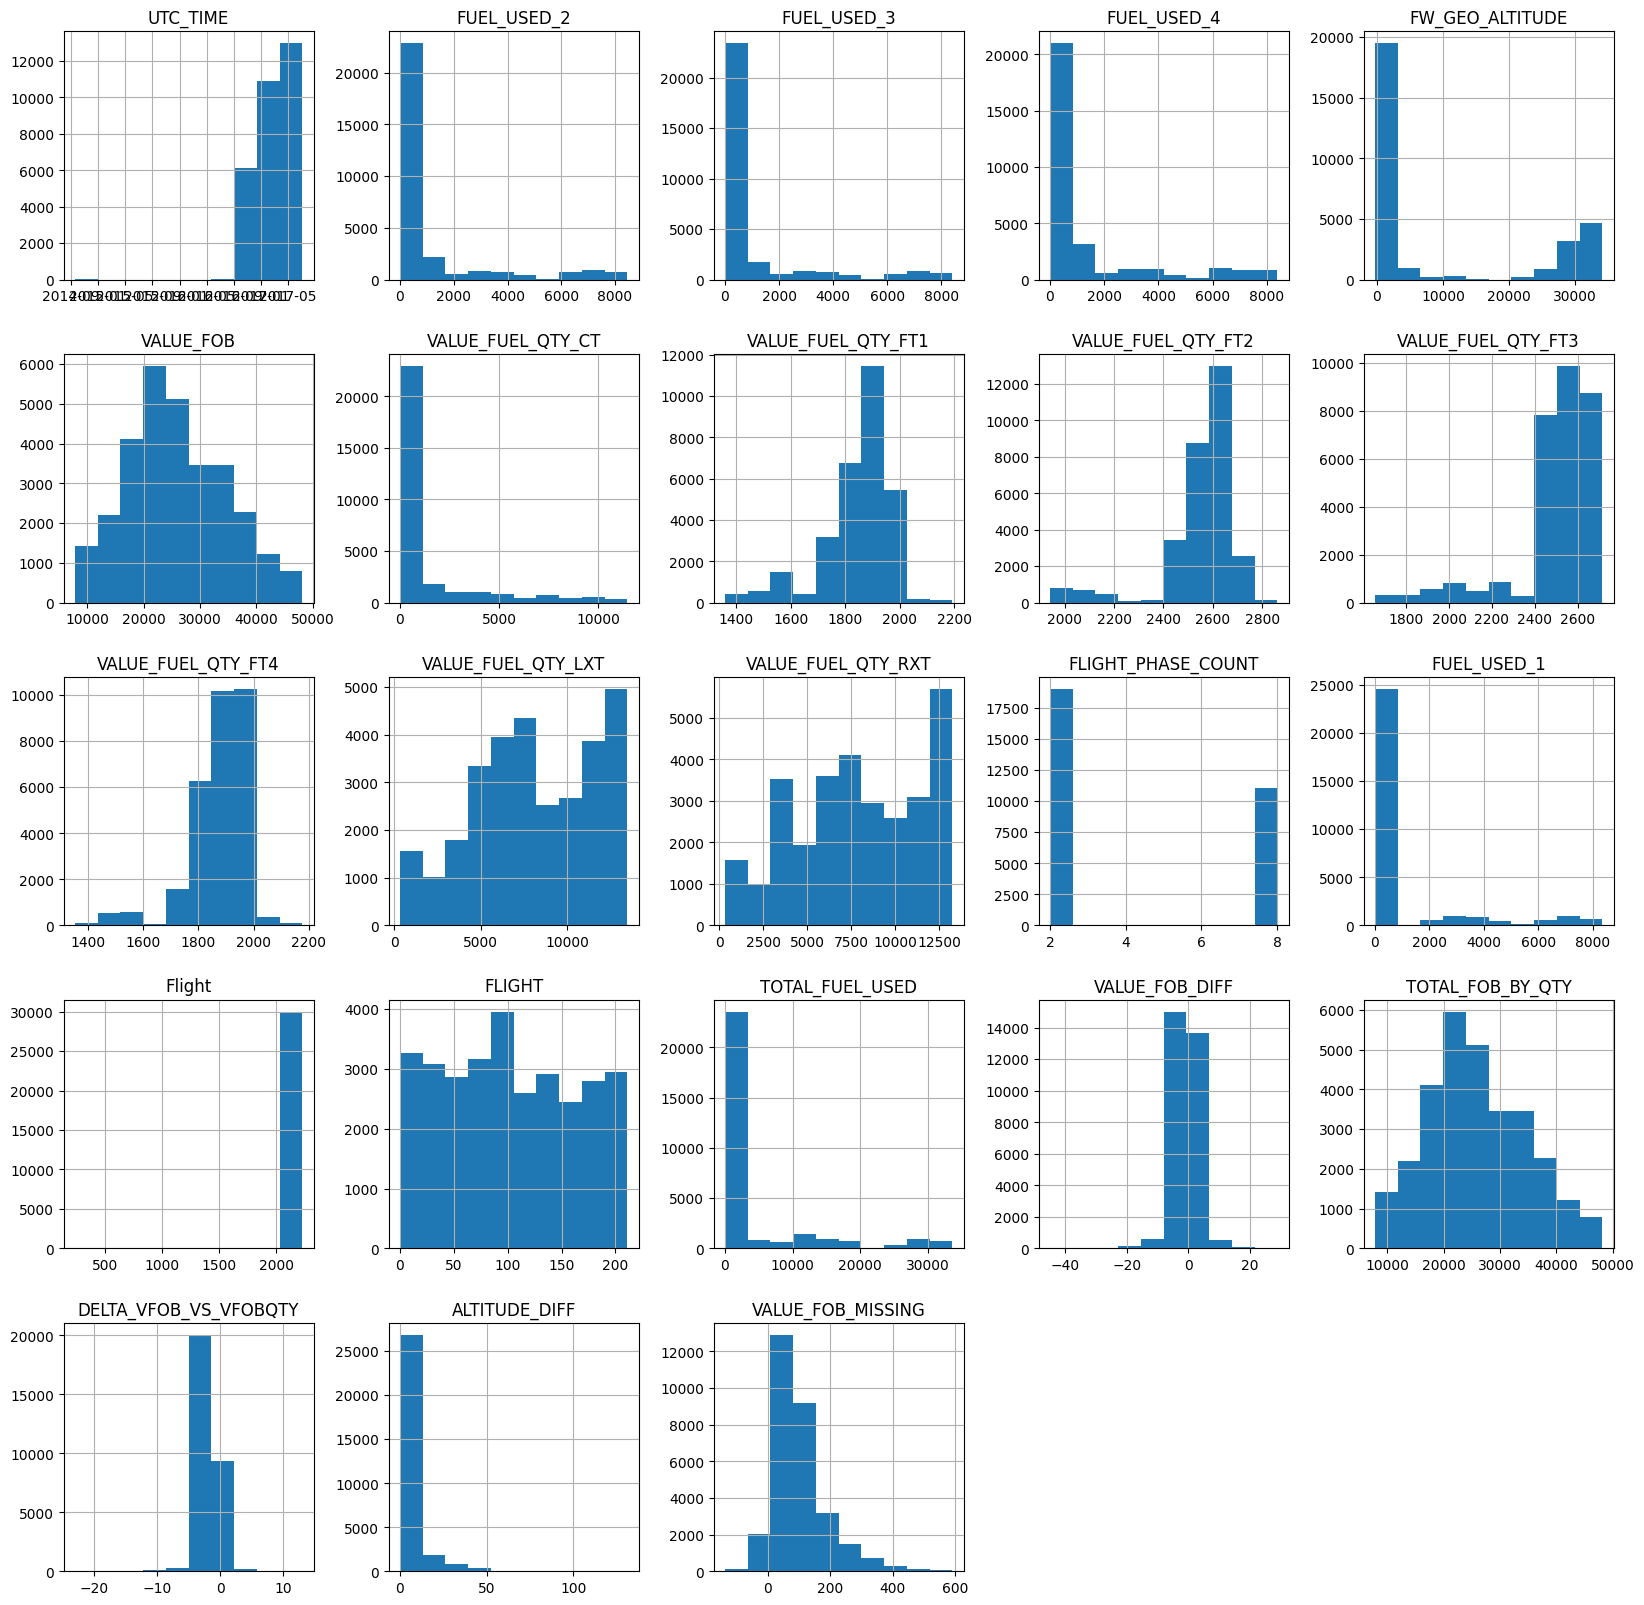

Dataset 6 shape: (164605, 26)
Dataset 6 unique flights: 978


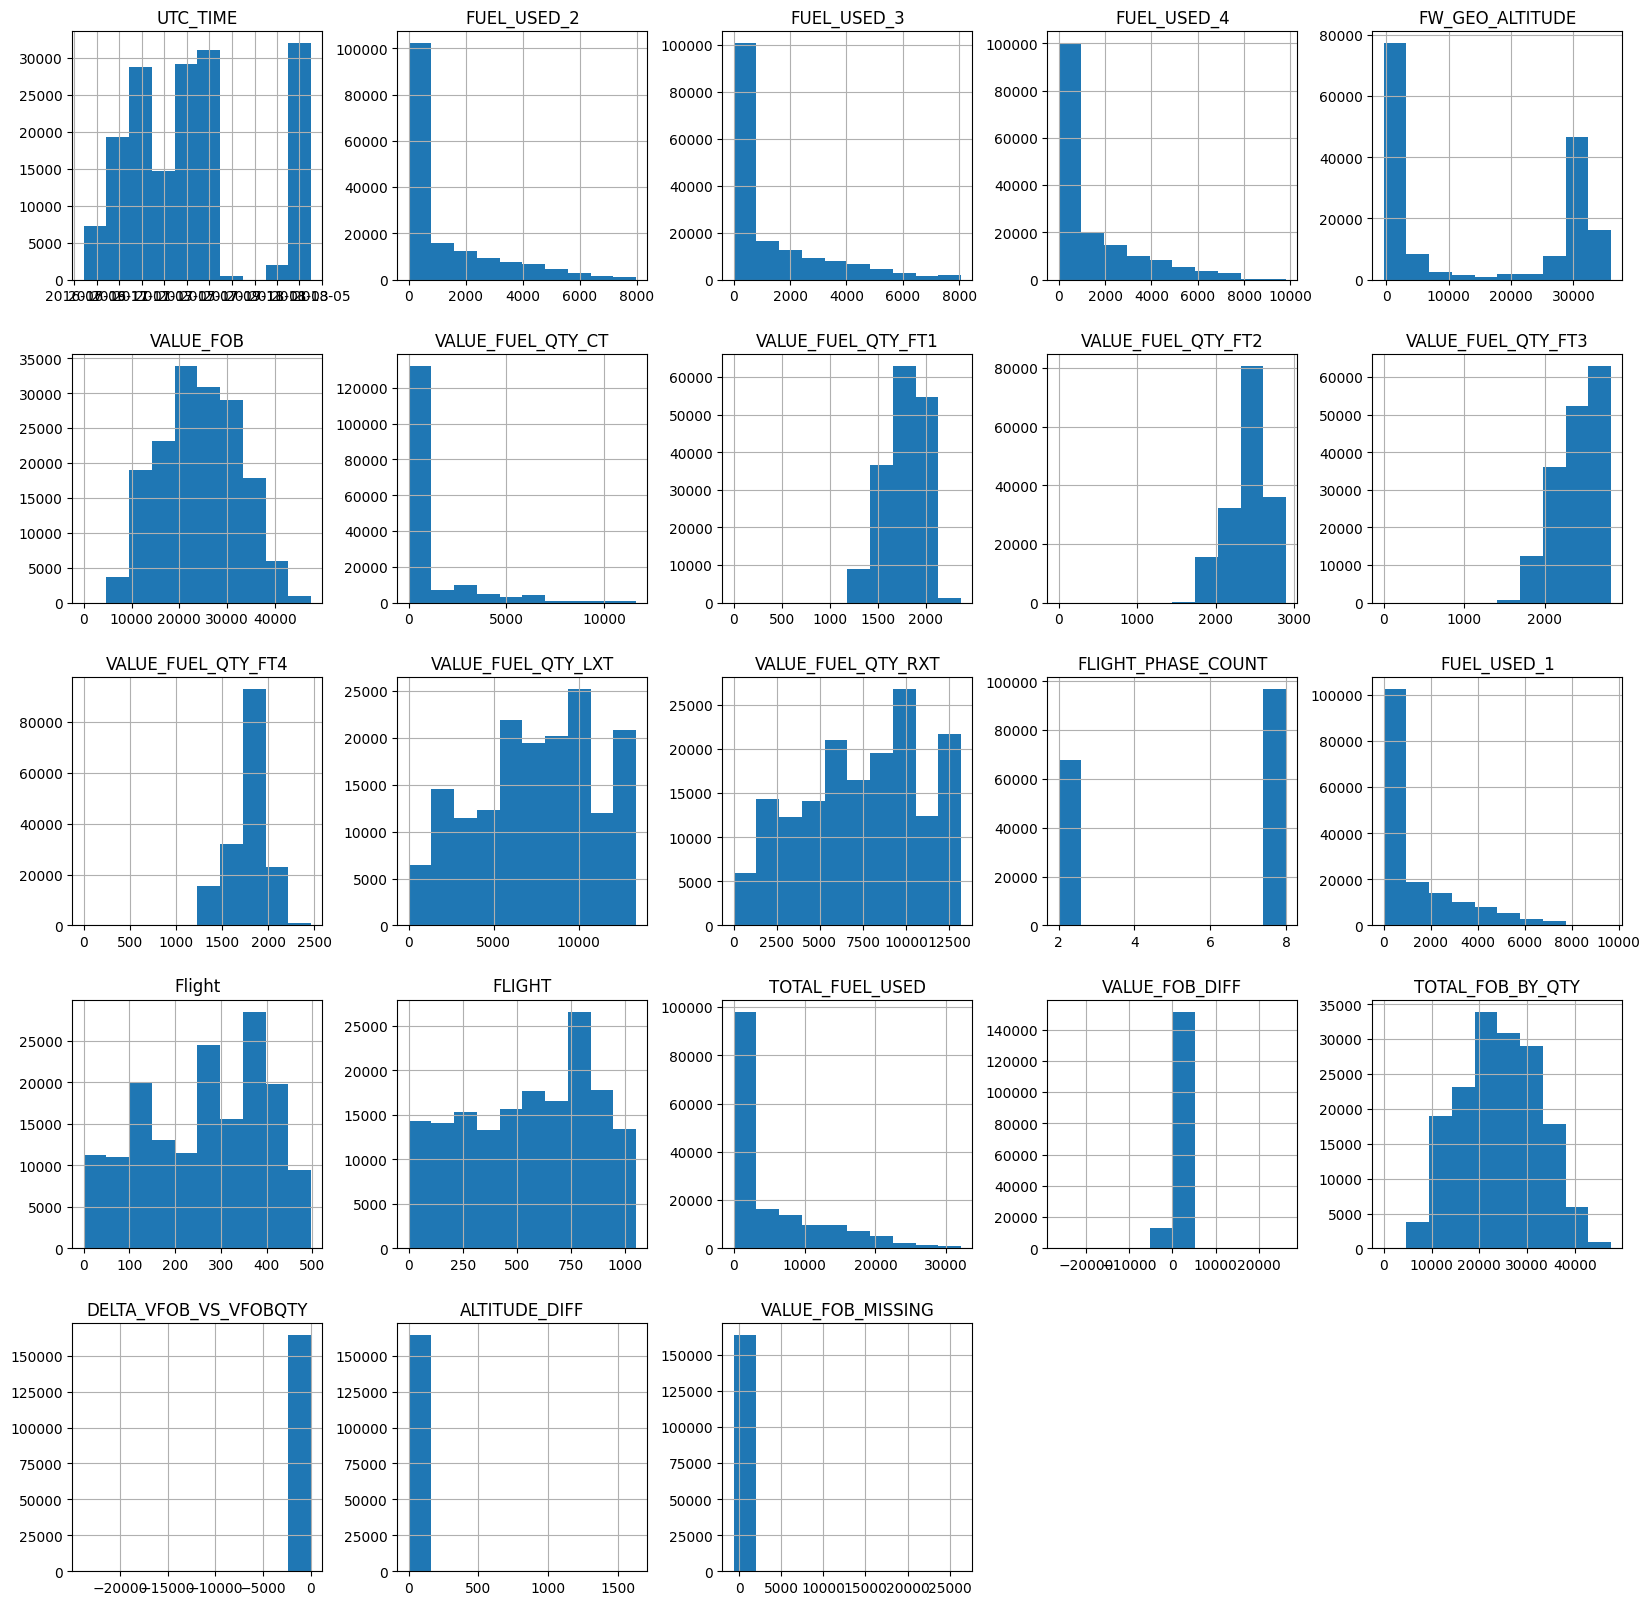

Dataset 7 shape: (151035, 26)
Dataset 7 unique flights: 886


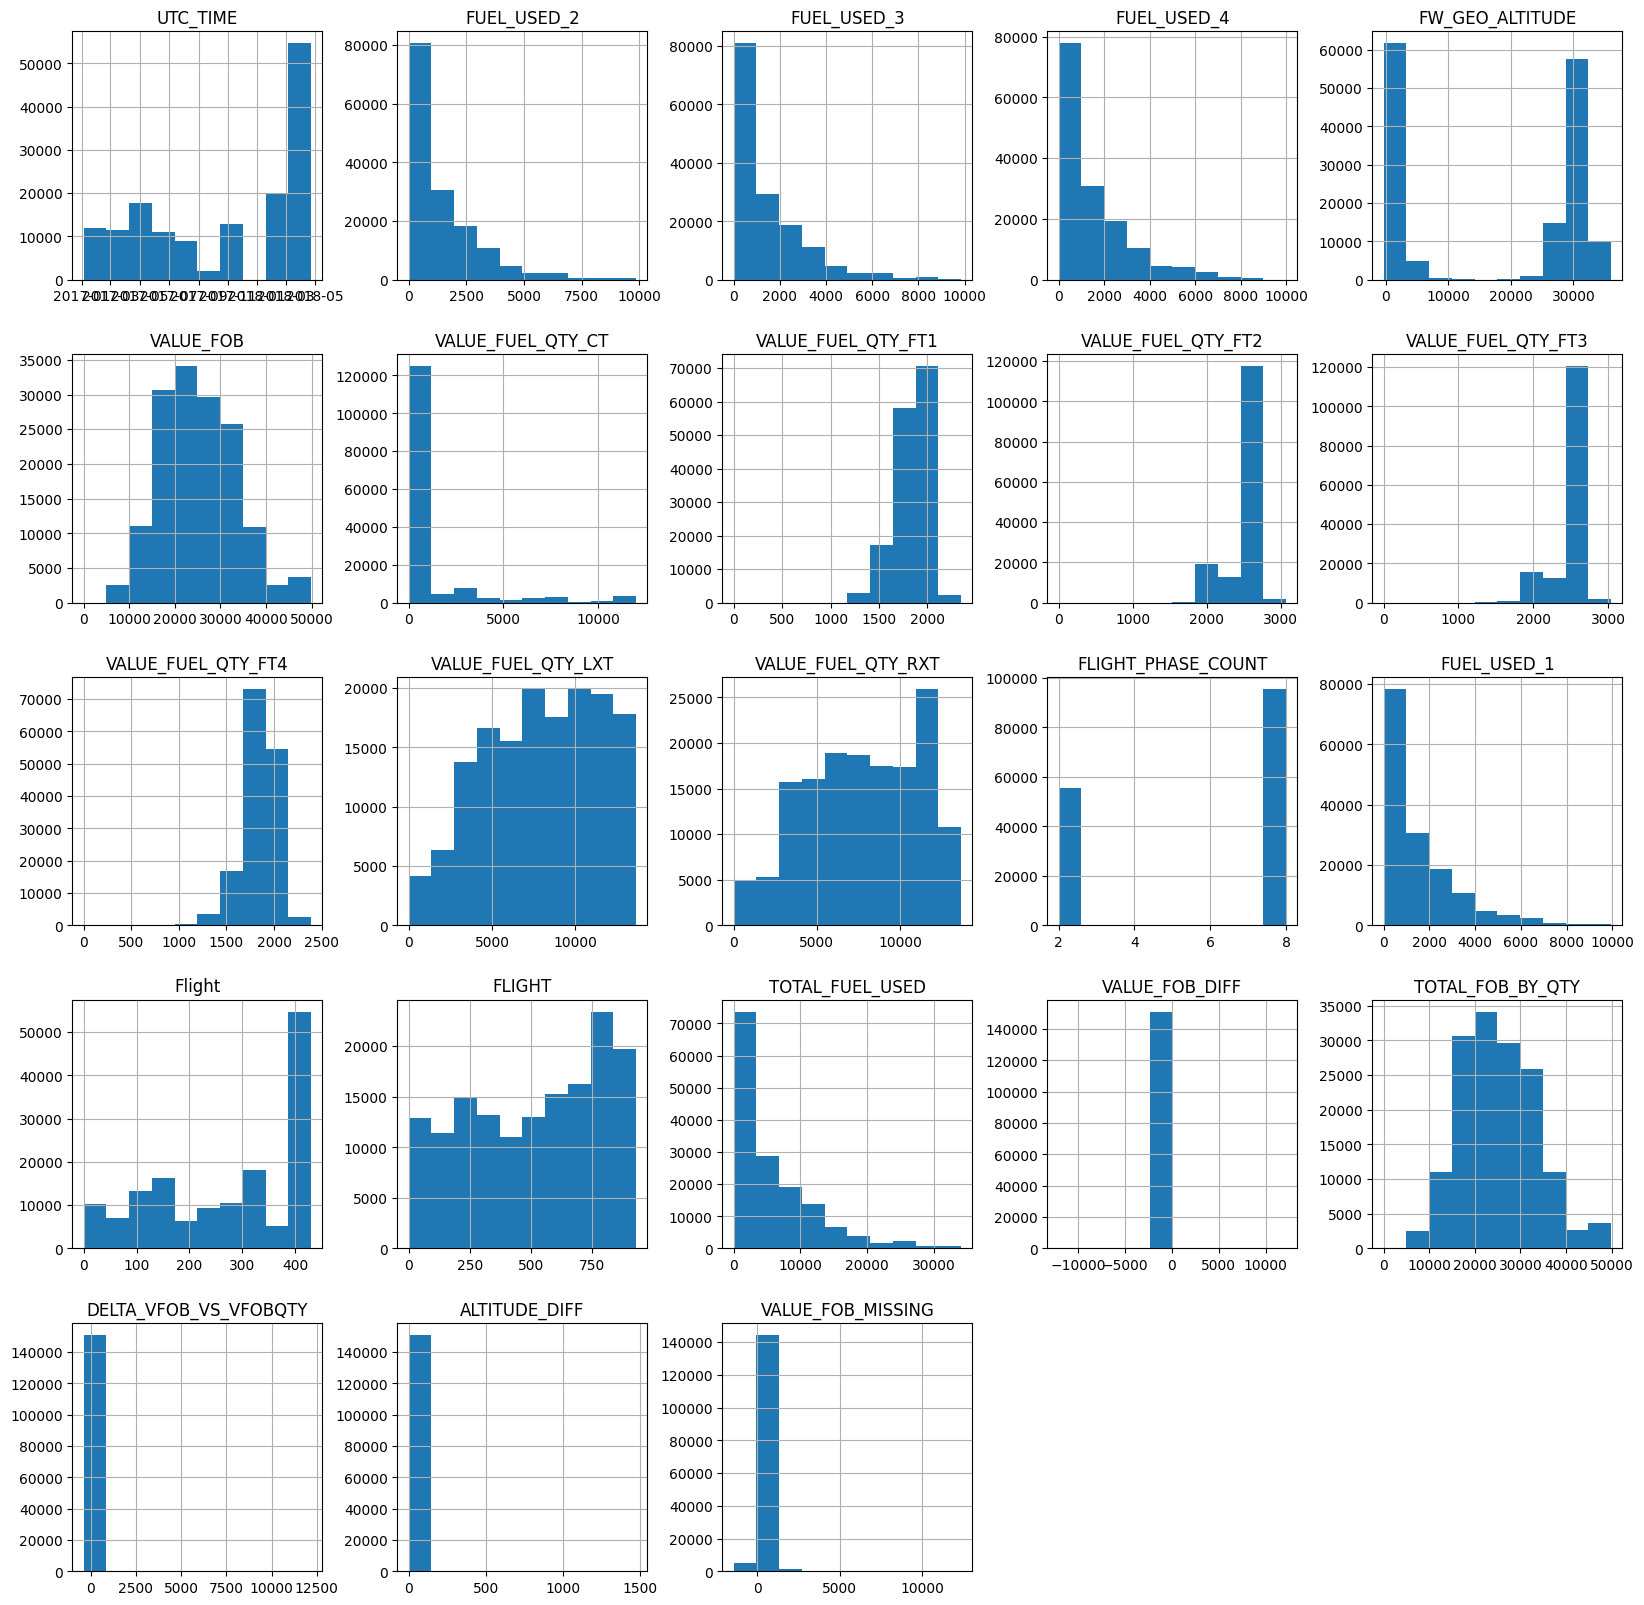

Dataset 8 shape: (164605, 26)
Dataset 8 unique flights: 978


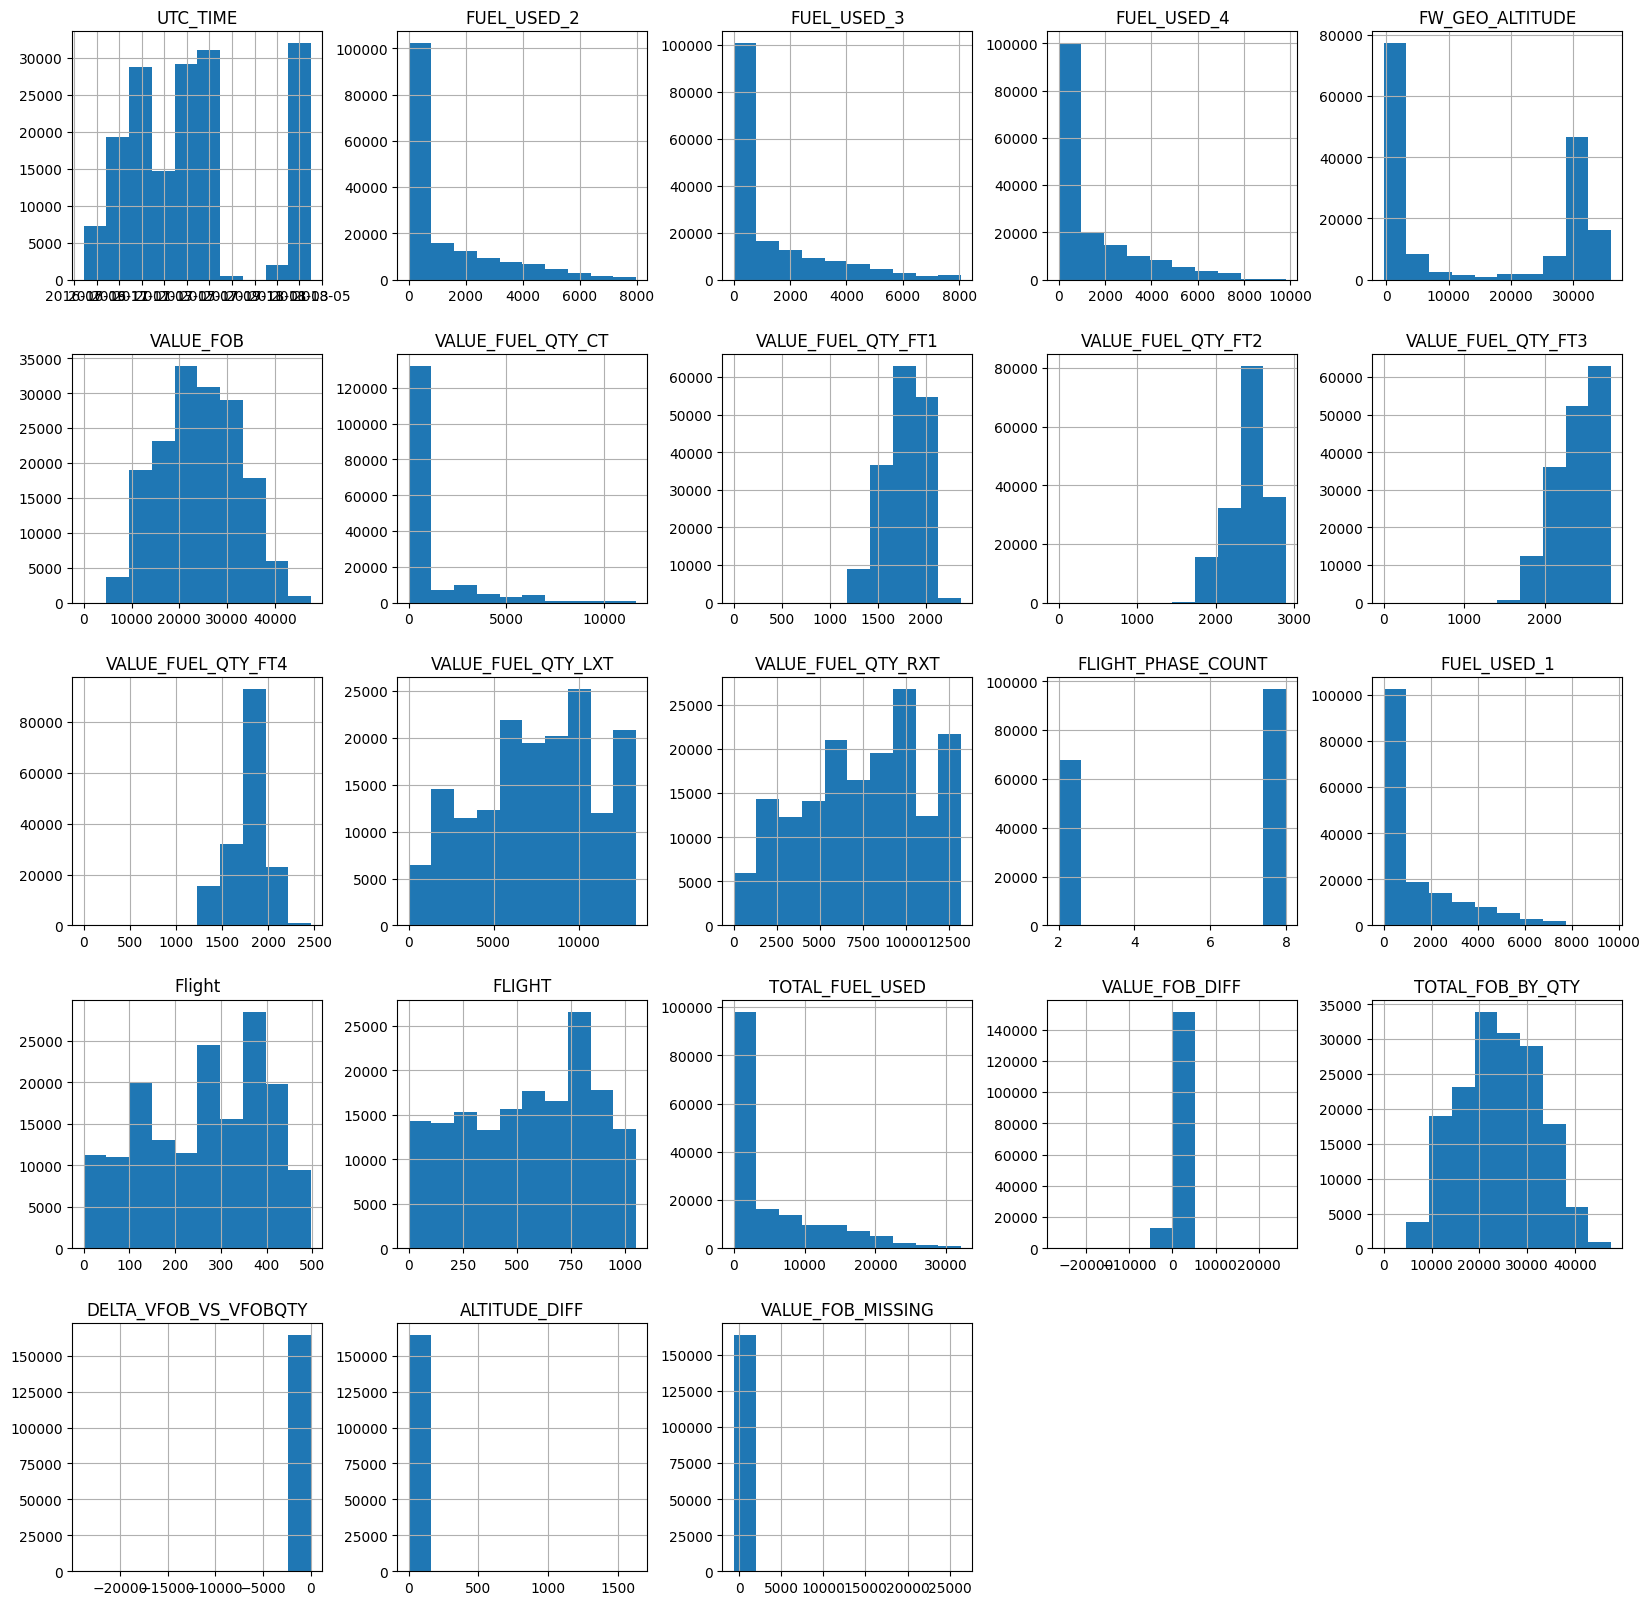

Dataset 9 shape: (164605, 26)
Dataset 9 unique flights: 978


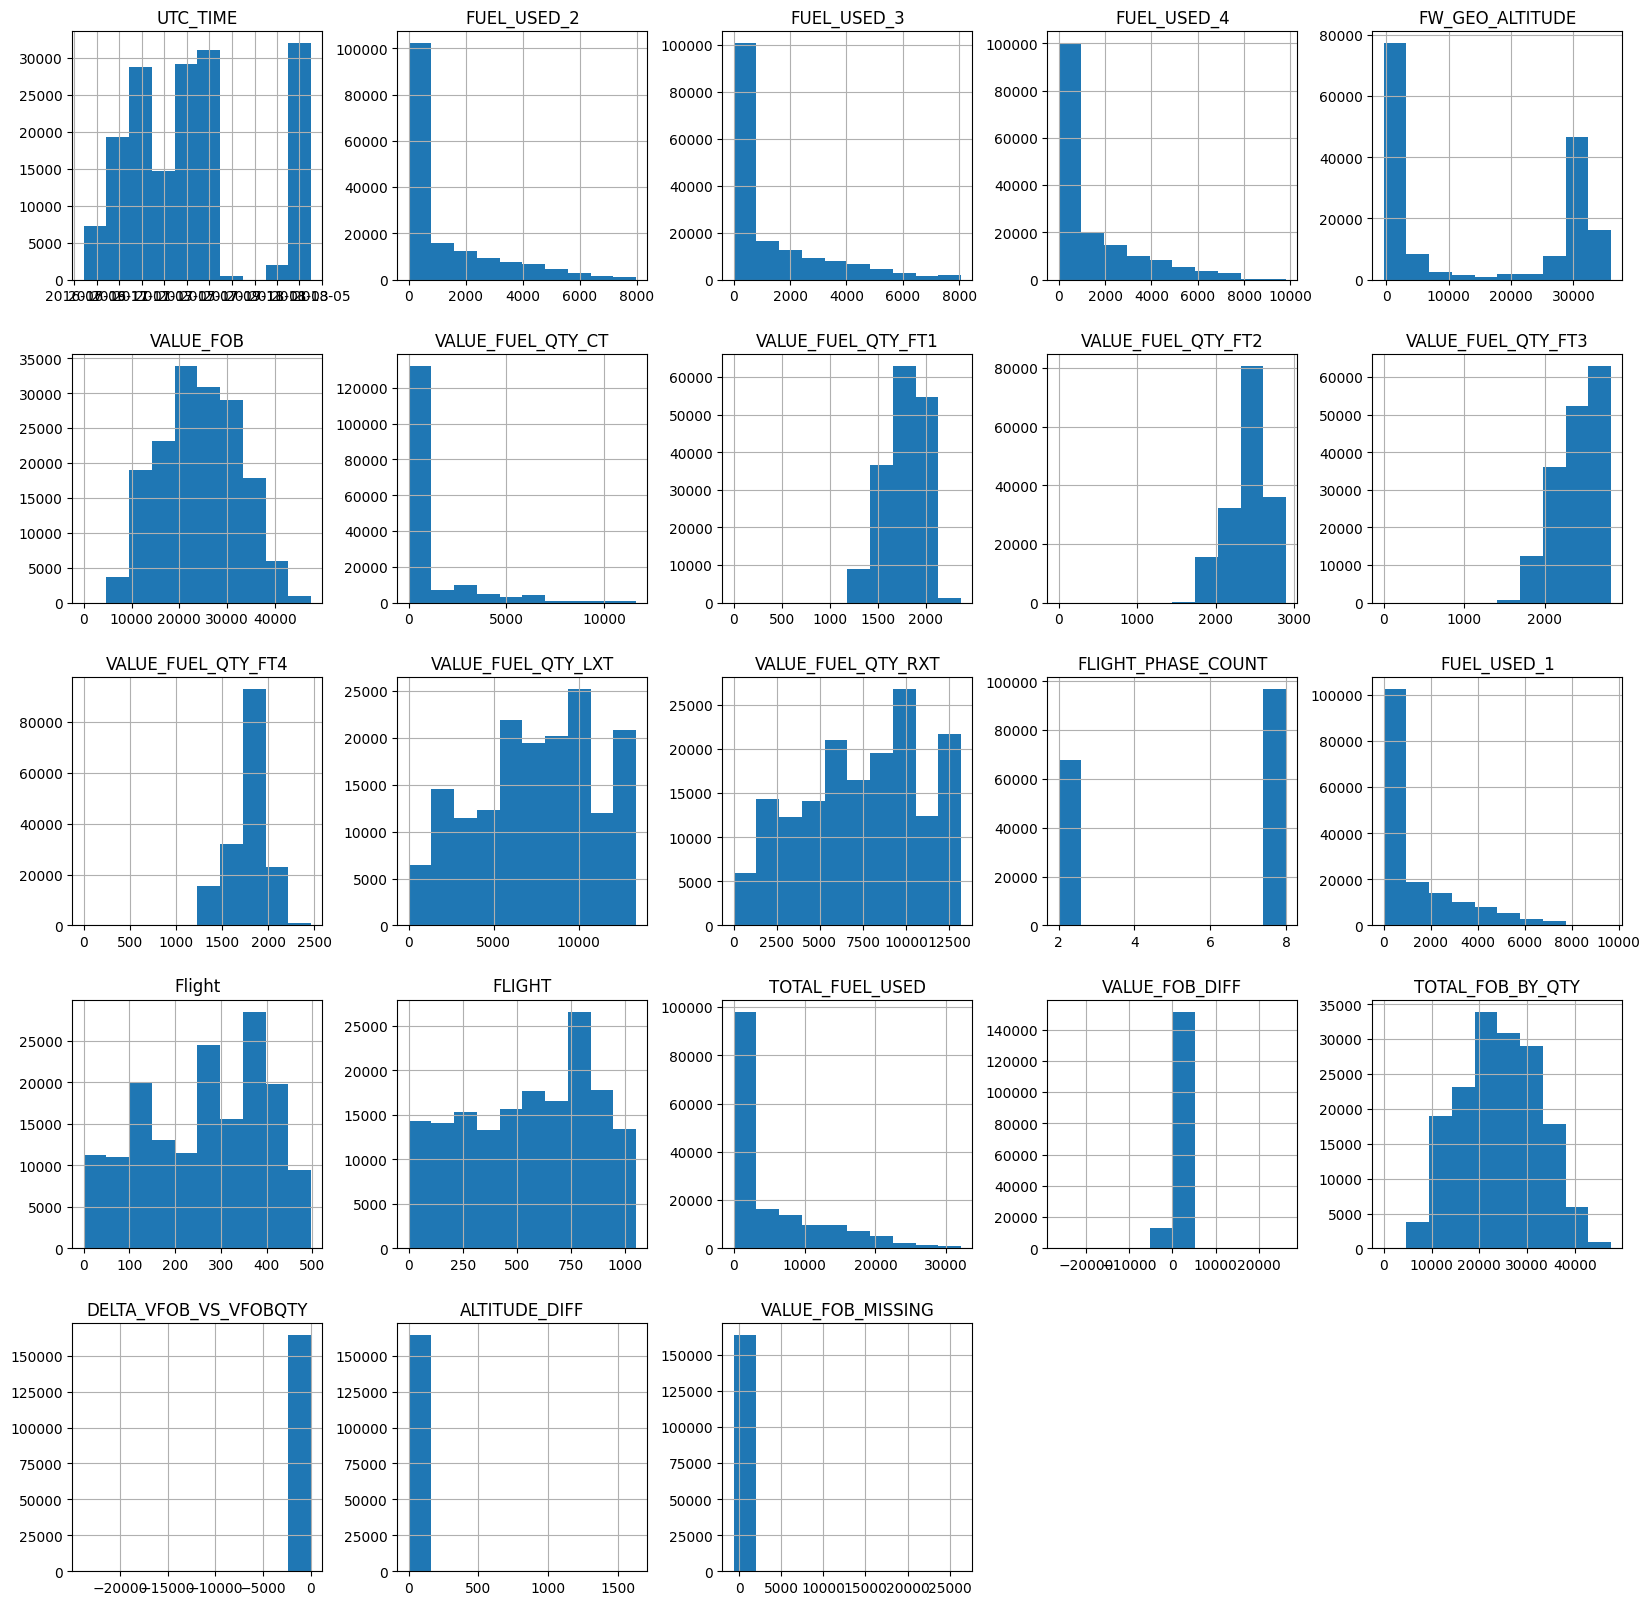

Dataset 10 shape: (164605, 26)
Dataset 10 unique flights: 978


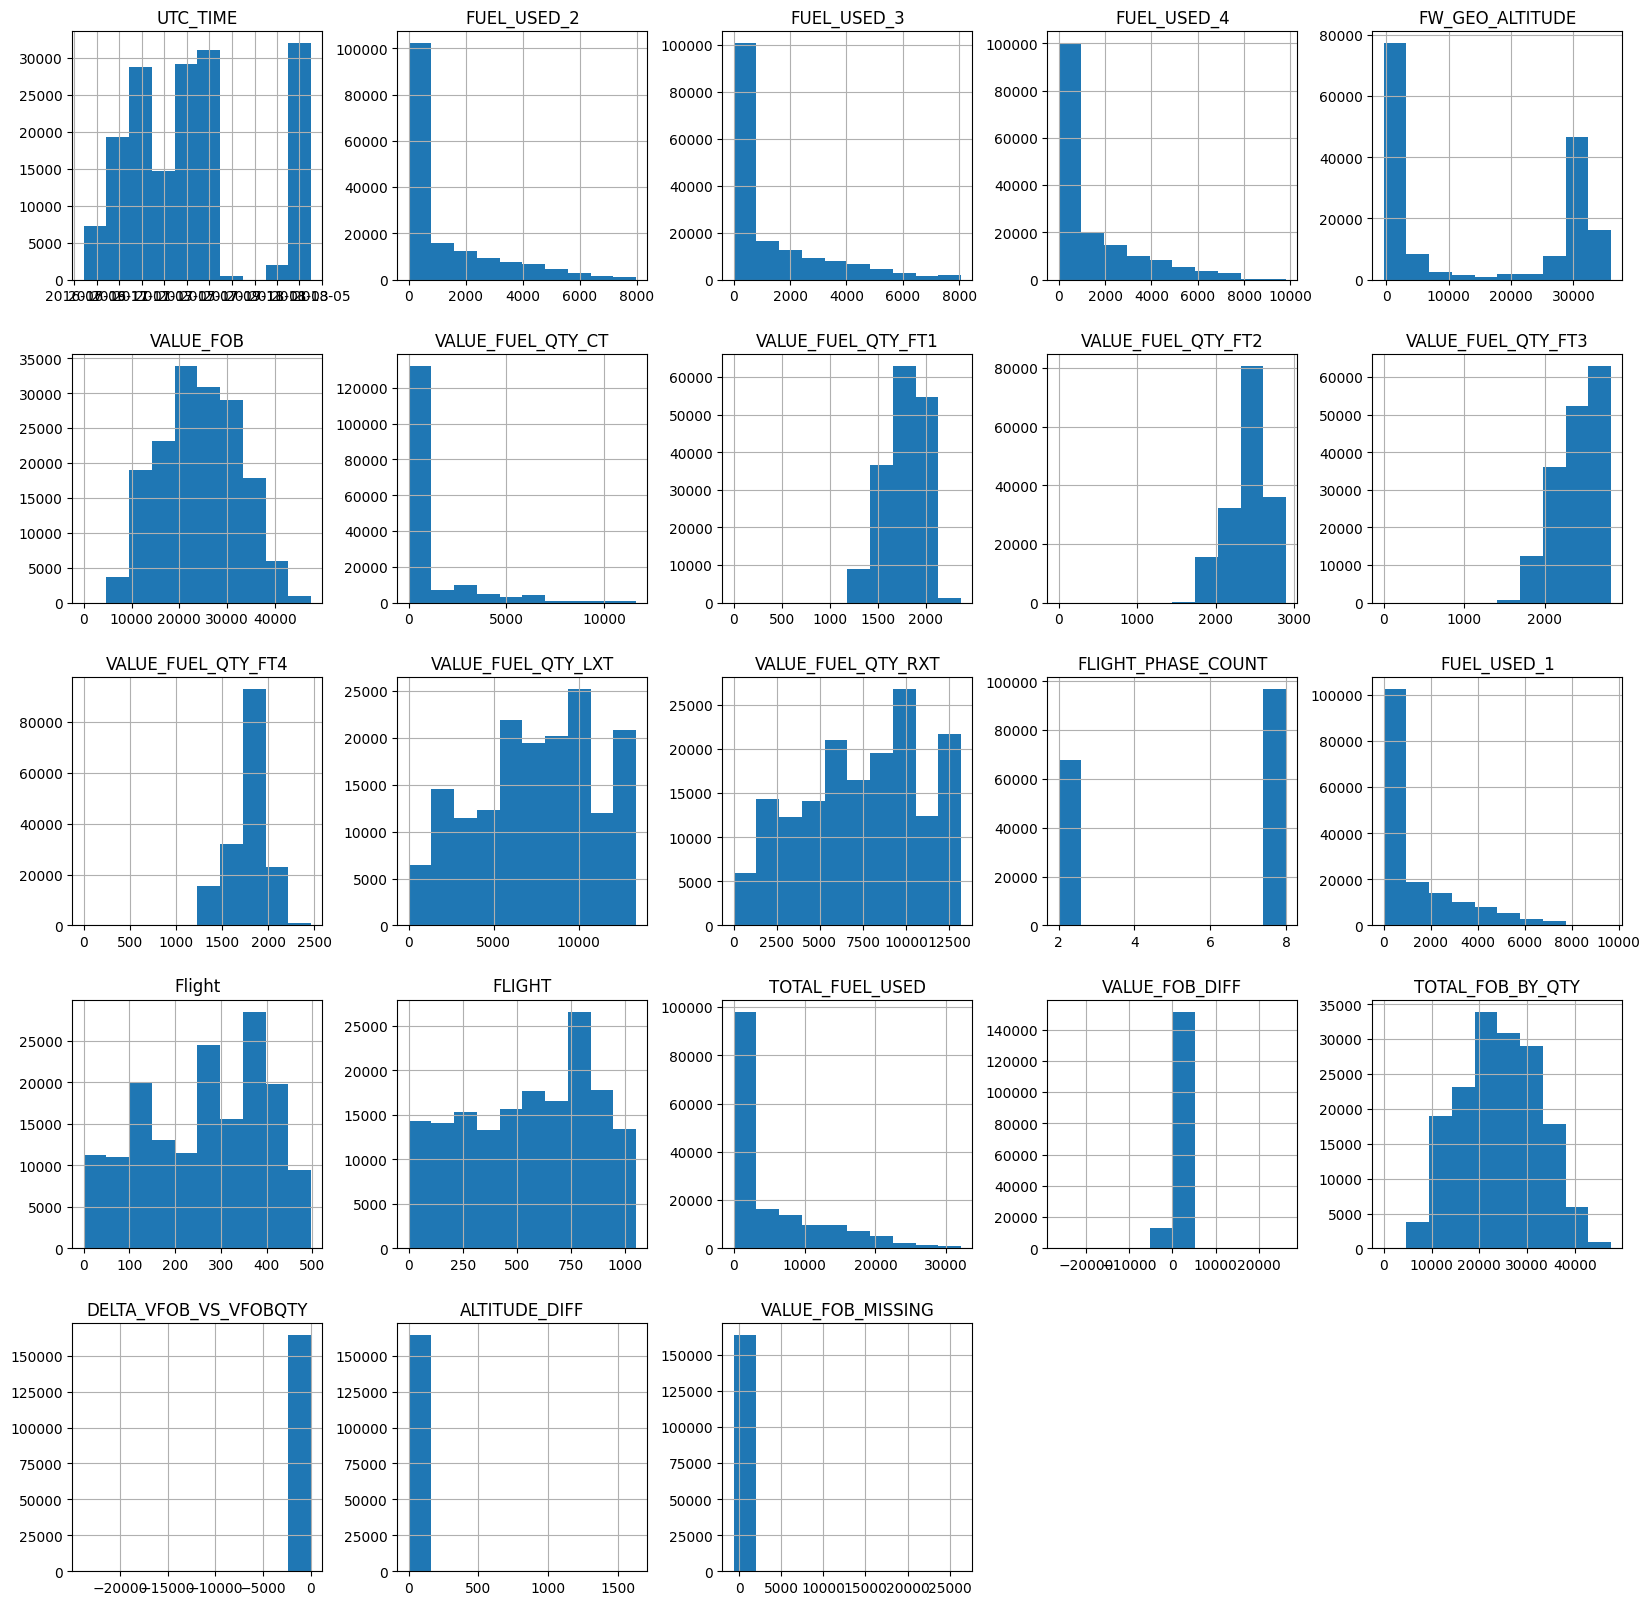

In [92]:
# distribution of the columns 
for i, dataset in enumerate(datasets_with_new_features):
    print(f'Dataset {i} shape: {dataset.shape}')
    print(f'Dataset {i} unique flights: {dataset["FLIGHT"].nunique()}')
    dataset.hist(figsize=(20,20))
    plt.show()

# Dropping Outliers

Since out data is not normally distributed most of the time we're using IQR for the outlier detection

In [93]:
# count number of outliers outside of 95% confidence interval
def drop_outliers(dataset):
    # create copy of dataset
    dataset_tmp = dataset.copy()
    
    for column in dataset_tmp.columns:
        # skip columns that are not numeric
        if dataset_tmp[column].dtype != 'float64':
            continue
        
        # calculate 95% confidence interval
        lower_bound, upper_bound = np.percentile(dataset_tmp[column], [2.5, 97.5])
        
        # count number of outliers
        outliers = dataset_tmp[column][(dataset_tmp[column] < lower_bound) | (dataset_tmp[column] > upper_bound)]
        print(f'Column {column} has {outliers.shape[0]} outliers')
        
        # delete outliers
        dataset_tmp.drop(outliers.index, inplace=True)
        
    return dataset_tmp

In [94]:
datasets_without_outliers = [drop_outliers(dataset) for dataset in datasets_with_new_features]
datasets_without_outliers_with_fuel_leak = [drop_outliers(dataset) for dataset in datasets_with_new_features_with_fuel_leak]

Column FLIGHT_PHASE_COUNT has 0 outliers
Column FUEL_USED_1 has 712 outliers
Column FUEL_USED_2 has 728 outliers
Column FUEL_USED_3 has 690 outliers
Column FUEL_USED_4 has 656 outliers
Column FW_GEO_ALTITUDE has 624 outliers
Column VALUE_FOB has 590 outliers
Column VALUE_FUEL_QTY_CT has 281 outliers
Column VALUE_FUEL_QTY_FT1 has 536 outliers
Column VALUE_FUEL_QTY_FT2 has 512 outliers
Column VALUE_FUEL_QTY_FT3 has 490 outliers
Column VALUE_FUEL_QTY_FT4 has 450 outliers
Column VALUE_FUEL_QTY_LXT has 441 outliers
Column VALUE_FUEL_QTY_RXT has 412 outliers
Column FLIGHT has 0 outliers
Column TOTAL_FUEL_USED has 406 outliers
Column VALUE_FOB_DIFF has 315 outliers
Column TOTAL_FOB_BY_QTY has 367 outliers
Column DELTA_VFOB_VS_VFOBQTY has 282 outliers
Column ALTITUDE_DIFF has 337 outliers
Column VALUE_FOB_MISSING has 320 outliers
Column FUEL_USED_2 has 0 outliers
Column FUEL_USED_3 has 0 outliers
Column FUEL_USED_4 has 0 outliers
Column FW_GEO_ALTITUDE has 0 outliers
Column VALUE_FOB has 0 out

In [95]:
datasets_without_outliers

[                  UTC_TIME         MSN Flight  FLIGHT_PHASE_COUNT  \
 33917  2016-10-07 07:40:16  A400M-0002  V0926                 2.0   
 33918  2016-10-07 07:40:17  A400M-0002  V0926                 2.0   
 33919  2016-10-07 07:40:18  A400M-0002  V0926                 2.0   
 33920  2016-10-07 07:40:19  A400M-0002  V0926                 2.0   
 33921  2016-10-07 07:40:20  A400M-0002  V0926                 2.0   
 ...                    ...         ...    ...                 ...   
 589619 2016-10-07 12:14:54  A400M-0002  V0927                 8.0   
 589620 2016-10-07 12:14:55  A400M-0002  V0927                 8.0   
 589621 2016-10-07 12:14:56  A400M-0002  V0927                 8.0   
 589622 2016-10-07 12:14:57  A400M-0002  V0927                 8.0   
 589623 2016-10-07 12:14:58  A400M-0002  V0927                 8.0   
 
         FUEL_USED_1  FUEL_USED_2  FUEL_USED_3  FUEL_USED_4  FW_GEO_ALTITUDE  \
 33917      18.68552     14.60292     11.80057     8.456606         539.7343  

## Merge all datasets

In [96]:
# merge all datasets into one
merged_dataset = pd.concat(datasets_without_outliers)
merged_dataset_with_fuel_leak = pd.concat(datasets_without_outliers_with_fuel_leak)

In [97]:
# drop column FLIGHT_PHASE_COUNT since it is unnecessary
merged_dataset.drop(['FLIGHT_PHASE_COUNT'], axis=1, inplace=True)
merged_dataset_with_fuel_leak.drop('FLIGHT_PHASE_COUNT', axis=1, inplace=True)

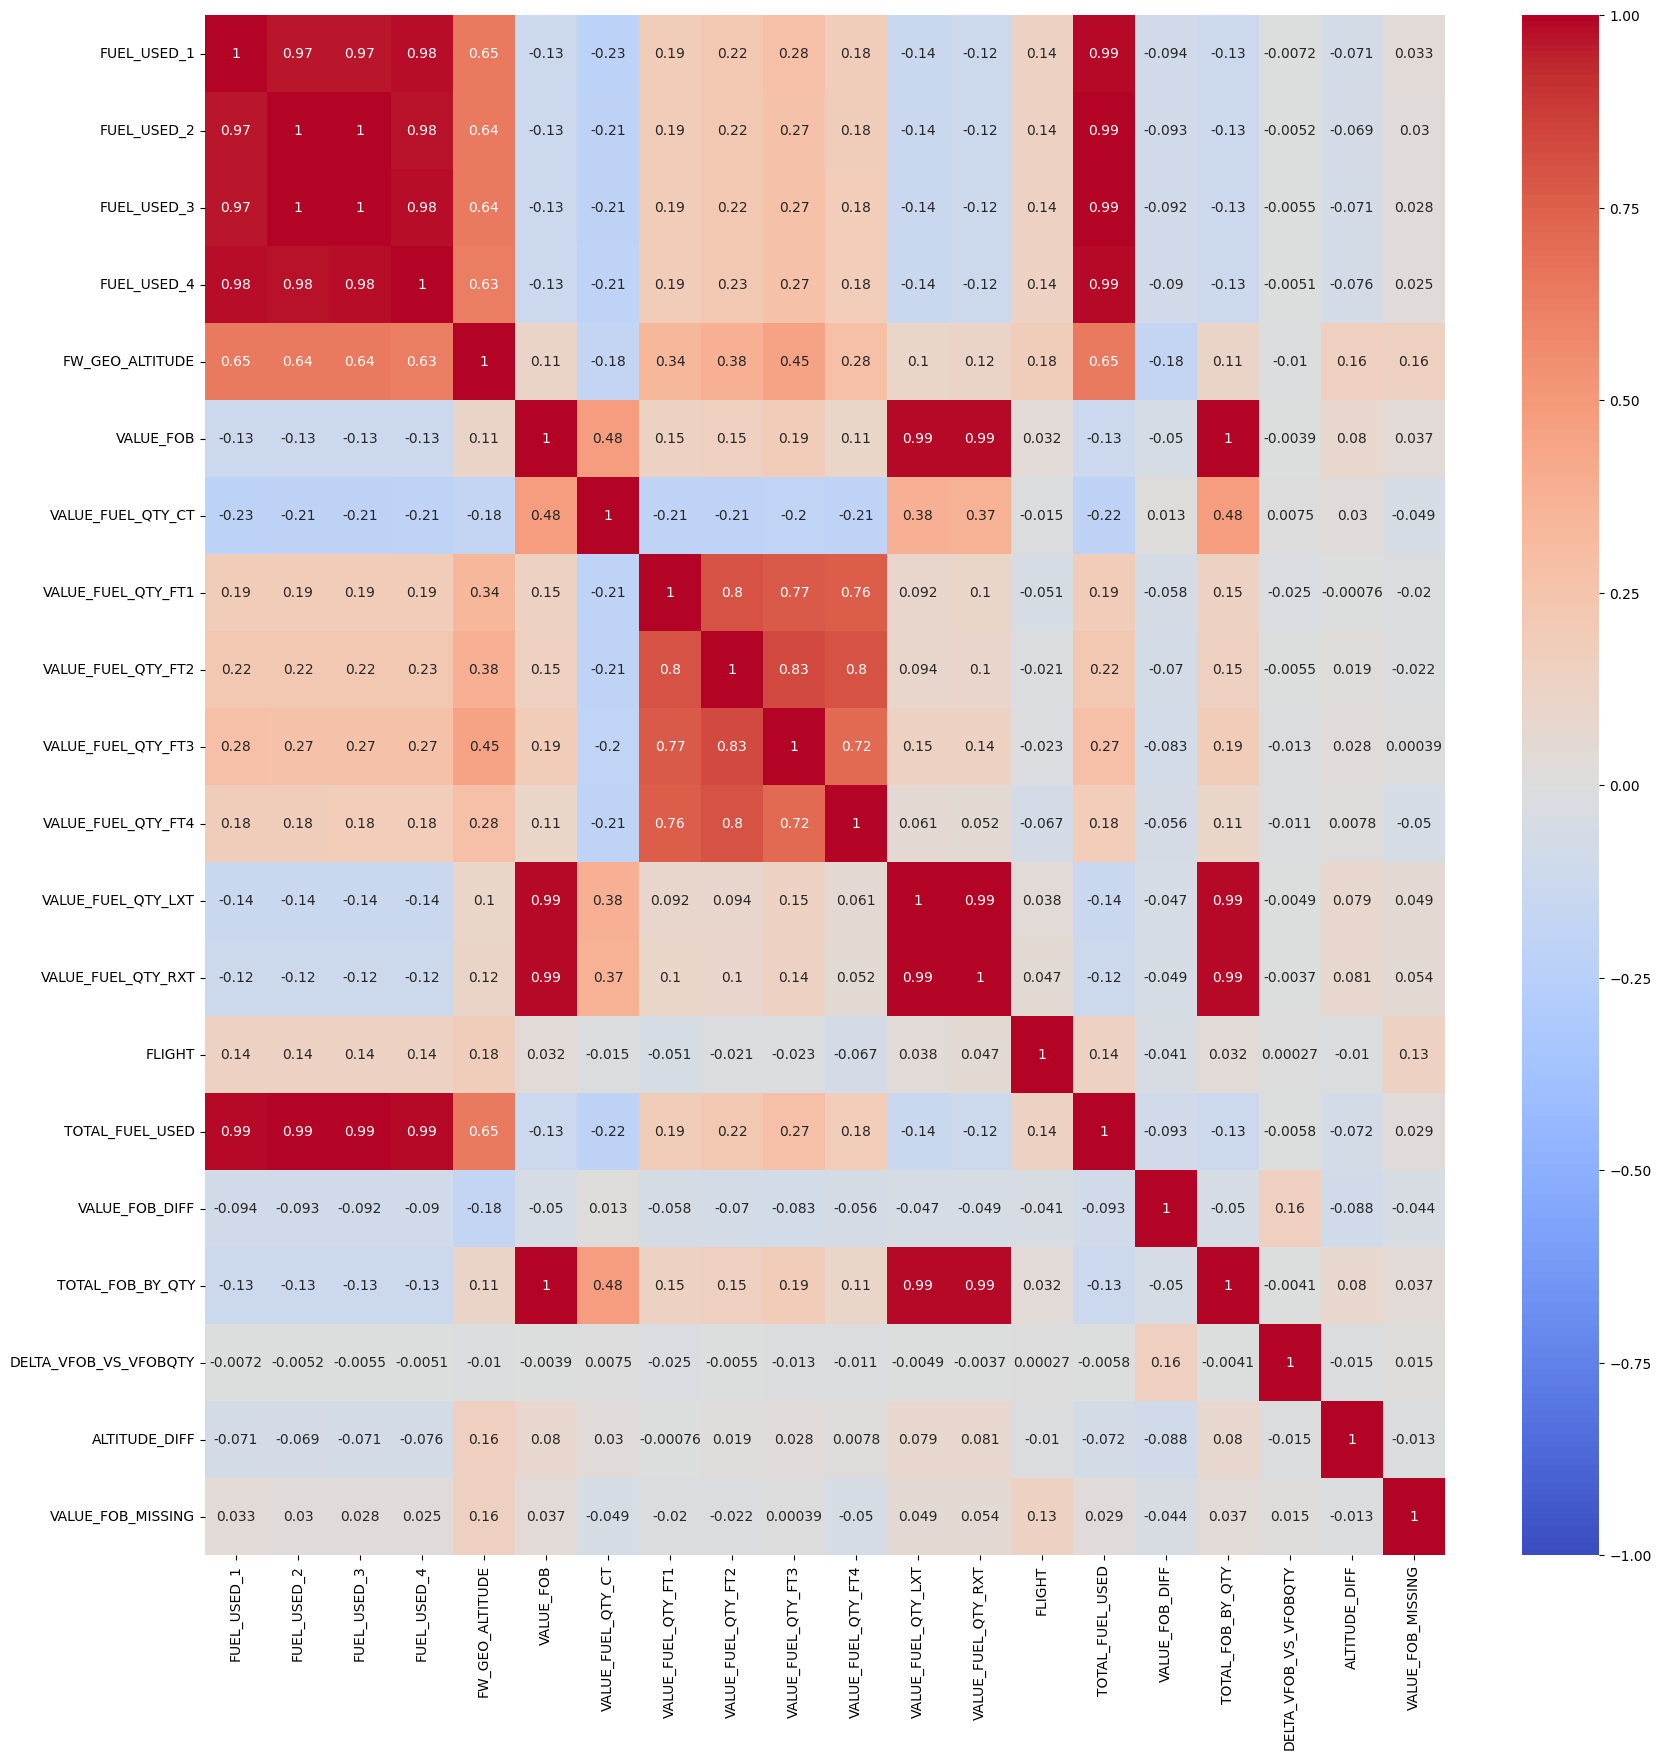

In [98]:
import seaborn as sns

# heatmap for numeric columns
fig = plt.figure(figsize=(20, 20))
sns.heatmap(merged_dataset.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


In [99]:
# if not exists, create generated_data folder
if not os.path.exists('generated_data'):
    os.makedirs('generated_data')

# save datasets into generated_data folder
merged_dataset.to_csv('generated_data/merged_dataset.csv', index=False)
merged_dataset_with_fuel_leak.to_csv('generated_data/merged_dataset_with_fuel_leak.csv', index=False)

<IPython.core.display.Javascript object>

## Get Derivated Dataset

In [100]:
numeric_columns = merged_dataset.select_dtypes(include=['float64']).columns

In [101]:
# new dataset with resampled data diff for numeric  columns
merged_dataset_diff = pd.DataFrame()
merged_dataset_with_fuel_leak_diff = pd.DataFrame()
 
for column in numeric_columns:
    if column == 'ALTITUDE_DIFF' or column == 'VALUE_FOB_DIFF' or column == 'FLIGHT':
        merged_dataset_diff[column] = merged_dataset[column]
        merged_dataset_with_fuel_leak_diff[column] = merged_dataset_with_fuel_leak[column]
    merged_dataset_diff[column] = merged_dataset[column].diff()
    merged_dataset_with_fuel_leak_diff[column] = merged_dataset_with_fuel_leak[column].diff()
    
# fillna with 0
merged_dataset_diff.fillna(0, inplace=True)
merged_dataset_with_fuel_leak_diff.fillna(0, inplace=True)

In [102]:
# save datasets into generated_data folder
merged_dataset_diff.to_csv('generated_data/merged_dataset_diff.csv', index=False)
merged_dataset_with_fuel_leak_diff.to_csv('generated_data/merged_dataset_with_fuel_leak_diff.csv', index=False)

## Scaling

In [103]:
# define scaler
scaler = StandardScaler()
 
# fit_transform on merged dataset
scaled_data = scaler.fit_transform(merged_dataset_diff[numeric_columns])
scaled_data_with_fuel_leak = scaler.fit_transform(merged_dataset_with_fuel_leak_diff[numeric_columns])

# convert scaled_dataset to dataframe
scaled_dataset = pd.DataFrame(scaled_data, columns=numeric_columns)
scaled_dataset_with_fuel_leak = pd.DataFrame(scaled_data_with_fuel_leak, columns=numeric_columns)

scaled_dataset

FUEL_USED_1  FUEL_USED_2  FUEL_USED_3  FUEL_USED_4  FW_GEO_ALTITUDE  \
0         -0.000015    -0.000015    -0.000015    -0.000015        -0.000048   
1          0.001046     0.001095     0.001181     0.001044        -0.000046   
2          0.001043     0.001087     0.001082     0.001065        -0.000032   
3          0.001046     0.001089     0.001078     0.001071        -0.000431   
4          0.001040     0.001095     0.001079     0.001073        -0.000055   
...             ...          ...          ...          ...              ...   
433269     0.003119     0.003246     0.002837     0.003144         0.001552   
433270     0.006254     0.006848     0.007274     0.006672        -0.002448   
433271     0.003509     0.003216     0.003221     0.003145        -0.000048   
433272     0.003119     0.003199     0.003633     0.003527         0.001552   
433273     0.000381     0.000388     0.000395     0.000381         0.000752   

        VALUE_FOB  VALUE_FUEL_QTY_CT  VALUE_FUEL_QTY_FT1  VALUE_FUEL_QTY_FT2  \
0        0.000013                0.0            0.000067            0.000069   
1        0.000013                0.0            0.000067            0.000069   
2       -0.001950                0.0            0.000067            0.000069   
3        0.000013                0.0            0.000067           -0.068849   
4       -0.005874                0.0           -0.083152            0.000069   
...           ...                ...                 ...                 ...   
433269   0.001975                0.0           -0.083152            0.000069   
433270  -0.005874                0.0           -0.083152           -0.068849   
433271  -0.001950                0.0            0.000067           -0.068849   
433272  -0.003912                0.0            0.000067            0.000069   
433273   0.000013                0.0           -0.083152            0.068986   

        VALUE_FUEL_QTY_FT3  VALUE_FUEL_QTY_FT4  VALUE_FUEL_QTY_LXT  \
0                 0.000069            0.000055            0.000007   
1                 0.000069            0.000055            0.000007   
2                 0.000069            0.000055            0.000007   
3                 0.000069            0.000055           -0.004490   
4                 0.000069            0.000055            0.000007   
...                    ...                 ...                 ...   
433269            0.000069            0.074045           -0.004490   
433270            0.000069            0.074045           -0.004490   
433271            0.000069            0.074045            0.000007   
433272           -0.066672            0.000055           -0.004490   
433273           -0.066672            0.000055           -0.004490   

        VALUE_FUEL_QTY_RXT    FLIGHT  TOTAL_FUEL_USED  VALUE_FOB_DIFF  \
0                 0.000006 -0.000726        -0.000015   -9.018236e-07   
1                 0.000006 -0.000726         0.001118    3.907358e-01   
2                 0.000006 -0.000726         0.001095   -3.907376e-01   
3                 0.004505 -0.000726         0.001097    3.907358e-01   
4                 0.000006 -0.000726         0.001097   -1.172211e+00   
...                    ...       ...              ...             ...   
433269            0.004505 -0.000726         0.003162    7.814725e-01   
433270            0.004505 -0.000726         0.006923   -7.814743e-01   
433271           -0.004493 -0.000726         0.003353   -9.018236e-07   
433272            0.000006 -0.000726         0.003452   -3.907376e-01   
433273            0.004505 -0.000726         0.000396    7.814725e-01   

        TOTAL_FOB_BY_QTY  DELTA_VFOB_VS_VFOBQTY  ALTITUDE_DIFF  \
0               0.000013               0.000002  -4.768544e-07   
1               0.000013               0.000002  -1.062678e-03   
2               0.000013              -0.834874   3.477712e-03   
3              -0.001950               0.834878   9.561849e-02   
4              -0.001950              -1.669750  -

In [104]:
np.mean(scaled_data),np.std(scaled_data)

(-9.163156653894672e-20, 1.0)

In [105]:
# save scaled dataset to csv
scaled_dataset.to_csv('generated_data/scaled_dataset.csv', index=False)
scaled_dataset_with_fuel_leak.to_csv('generated_data/scaled_dataset_with_fuel_leak.csv', index=False) 

## PCA without Synthetic Leak Data

In [106]:
scaled_data = pd.read_csv('generated_data/scaled_dataset.csv')
scaled_data_with_fuel_leak = pd.read_csv('generated_data/scaled_dataset_with_fuel_leak.csv')

In [107]:
num_components = 15

# Create a PCA instance
pca = PCA()  

# Fit PCA on scaled_data
pca.fit(scaled_data)
 
# access values and vectors
print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())
 
# transform data 
pca_data = pca.transform(scaled_data)
 
# convert pca_data to dataframe
pca_dataset = pd.DataFrame(pca_data, columns=[f'PC{i}' for i in range(1, len(pca.components_)+1)])

[[-3.39823905e-01 -3.45836323e-01 -3.45095802e-01 -3.36993221e-01
  -2.34328278e-01  2.83492329e-01  1.80567566e-01  5.47590747e-02
   2.97748560e-02  1.12534538e-03  5.05688531e-02  2.78171660e-01
   2.75946449e-01 -2.43484886e-03 -3.50219003e-01  4.86568836e-03
   2.83493900e-01 -1.97004708e-03 -1.68829057e-02  3.26951511e-02]
 [-2.33563654e-01 -2.23277847e-01 -2.23770022e-01 -2.38092719e-01
  -2.28384208e-01 -3.57110893e-01 -1.96233281e-01 -1.77174464e-01
  -2.12410333e-01 -2.18807499e-01 -1.88923121e-01 -3.35529708e-01
  -3.38144286e-01  2.10431966e-02 -2.35406715e-01  9.36470305e-03
  -3.57121924e-01  6.33343896e-03 -4.16804345e-03  9.95392827e-03]
 [-7.33912255e-02 -7.86754711e-02 -7.86449077e-02 -7.44867165e-02
  -7.04423124e-02 -1.42148231e-01 -2.14289679e-01  4.68807775e-01
   4.69924290e-01  4.06470917e-01  4.59117156e-01 -1.67306798e-01
  -1.65718163e-01 -7.14222128e-02 -7.81202720e-02 -2.54064719e-03
  -1.42119307e-01 -1.16534256e-02 -3.63893517e-02 -2.57534376e-02]
 [ 5.94

In [108]:
pca_dataset.to_csv('generated_data/pca_dataset.csv', index=False)

In [109]:
explained_var = pca.explained_variance_ratio_

cumulative_var = np.cumsum(explained_var)

explained_var, cumulative_var

n_components = len(explained_var)

variance_trace = go.Bar(
    x=list(range(1, n_components + 1)),
    y=explained_var,
    name='Explained Variance'
)

cumulative_trace = go.Scatter(
    x=list(range(1, n_components + 1)),
    y=cumulative_var,
    mode='lines',
    name='Cumulative Explained Variance'
)

layout = go.Layout(
    title='PCA - Explained and Cumulative Variance',
    xaxis=dict(title='Principal Component'),
    yaxis=dict(title='Variance Explained'),
    legend=dict(x=0.7, y=1.0),
    template='plotly_dark'
)

fig = go.Figure(data=[variance_trace, cumulative_trace], layout=layout)

fig.show()

In [110]:
figures = []

for i, pc in enumerate(pca.components_, 1):
    fig = go.Figure()
    fig.add_trace(go.Bar(x=scaled_data.columns, y=pc))
    fig.update_layout(title=f"Principal Component {i}", xaxis_title="Features", yaxis_title="PC Value", template='plotly_dark')
    figures.append(fig)
for fig in figures[0:6]:
    fig.show()

KeyError: 'FLIGHT_PHASE_COUNT'

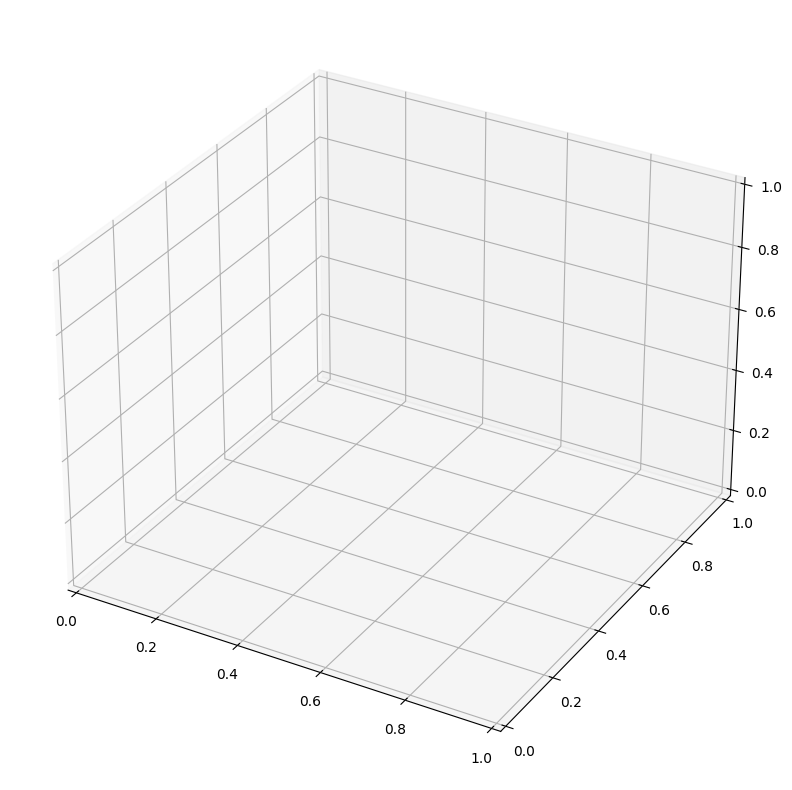

In [111]:
# 3d plot of first 3 principal components in different colors
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_dataset['PC1'], pca_dataset['PC2'], pca_dataset['PC3'], c=merged_dataset['FLIGHT_PHASE_COUNT'], cmap='coolwarm', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

## PCA with Leakage

In [112]:
num_components = 10

# Create a PCA instance
pca_with_fuel_leak = PCA()  

# Fit PCA on scaled_data
pca.fit(scaled_data_with_fuel_leak)
 
# access values and vectors
print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())
 
# transform data 
pca_data = pca.transform(scaled_data)
 
# convert pca_data to dataframe
pca_dataset_with_fuel_leak = pd.DataFrame(pca_data, columns=[f'PC{i}' for i in range(1, len(pca.components_)+1)])
pca_dataset_with_fuel_leak.to_csv('generated_data/pca_dataset_with_fuel_leak.csv', index=False)

[[-3.39818337e-01 -3.45830767e-01 -3.45090230e-01 -3.36987602e-01
  -2.34324092e-01  2.83497319e-01  1.80570038e-01  5.47678713e-02
   2.97775558e-02  1.15024032e-03  5.05419354e-02  2.78181925e-01
   2.75955790e-01 -2.43504892e-03 -3.50213252e-01  4.93406239e-03
   2.83498789e-01 -1.90253163e-03 -1.69260967e-02  3.27495531e-02]
 [-2.33538117e-01 -2.23252383e-01 -2.23744635e-01 -2.38065493e-01
  -2.28348169e-01 -3.57036152e-01 -1.96124413e-01 -1.77501903e-01
  -2.12509758e-01 -2.19155277e-01 -1.88993479e-01 -3.35451567e-01
  -3.38064805e-01  2.10562388e-02 -2.35380144e-01  9.28153205e-03
  -3.57047297e-01  6.37645213e-03 -3.98560564e-03  9.79262585e-03]
 [-7.34944245e-02 -7.87737330e-02 -7.87431846e-02 -7.45927132e-02
  -7.05788618e-02 -1.42303437e-01 -2.14482961e-01  4.68645279e-01
   4.69831439e-01  4.06280811e-01  4.59143115e-01 -1.67422499e-01
  -1.65844697e-01 -7.14276521e-02 -7.82242374e-02 -2.63636948e-03
  -1.42274034e-01 -1.19543212e-02 -3.64939076e-02 -2.58531527e-02]
 [ 5.89

In [113]:
explained_var = pca.explained_variance_ratio_

cumulative_var = np.cumsum(explained_var)

explained_var, cumulative_var

n_components = len(explained_var)

variance_trace = go.Bar(
    x=list(range(1, n_components + 1)),
    y=explained_var,
    name='Explained Variance'
)

cumulative_trace = go.Scatter(
    x=list(range(1, n_components + 1)),
    y=cumulative_var,
    mode='lines',
    name='Cumulative Explained Variance'
)

layout = go.Layout(
    title='PCA - Explained and Cumulative Variance',
    xaxis=dict(title='Principal Component'),
    yaxis=dict(title='Variance Explained'),
    legend=dict(x=0.7, y=1.0),
    template='plotly_dark'
)

fig = go.Figure(data=[variance_trace, cumulative_trace], layout=layout)

fig.show()

In [114]:
figures = []

for i, pc in enumerate(pca.components_, 1):
    fig = go.Figure()
    fig.add_trace(go.Bar(x=scaled_data.columns, y=pc))
    fig.update_layout(title=f"Principal Component {i}", xaxis_title="Features", yaxis_title="PC Value", template='plotly_dark')
    figures.append(fig)
for fig in figures[0:6]:
    fig.show()

## Testing


In [ ]:
# in df_test plot TOTAL_FUEL_USED for each flight
for flight in df_test['FLIGHT'].unique():
    # count number of rows for each flight
    if df_test[df_test['FLIGHT'] == flight].shape[0] > 1:
        # plot TOTAL_FUEL_USED for each flight x = UTC_TIME, y = TOTAL_FUEL_USED only plot if FLIGHT_PHASE_COUNT == 8
        if df_test[df_test['FLIGHT'] == flight]['FLIGHT_PHASE_COUNT'].iloc[0] == 2:
            plt.plot(df_test[df_test['FLIGHT'] == flight]['UTC_TIME'], df_test[df_test['FLIGHT'] == flight]['VALUE_FOB_DIFF'])
            plt.show()

In [ ]:
# for each flight and each flightphase calculate the std of VALUE_FOB_DIFF 

results = []
for flight in df_test['FLIGHT'].unique():
    result = {}
    for flightphase in df_test[df_test['FLIGHT'] == flight]['FLIGHT_PHASE_COUNT'].unique():
        result['FLIGHT'] = flight
        result['FLIGHT_PHASE'] = flightphase
        result['VALUE_FOB_DIFF_std'] = df_test[(df_test['FLIGHT'] == flight) & (df_test['FLIGHT_PHASE_COUNT'] == flightphase)]['VALUE_FOB_DIFF'].std()
        results.append(result)
        
results_df = pd.DataFrame(results)

pd.pivot_table(results_df, values='VALUE_FOB_DIFF_std', index=['FLIGHT'], columns=['FLIGHT_PHASE'], aggfunc=np.sum,  fill_value=0).sort_values(by=[11], ascending=False)


In [ ]:
# plot for dataset 0 for column LEAK_DETECTION_LEAK_FLOW
datasets[0].plot.scatter(x='UTC_TIME', y='LEAK_DETECTION_LEAK_FLOW')

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Extract numeric part from 'Flight' column
datasets[0]['Flight_number'] = datasets[0]['Flight'].str.extract('(\d+)').astype(int)

# Sort DataFrame by 'Flight_number'
sorted_df = datasets[0].sort_values(by='Flight_number')

fig = go.Figure()

# boxplot for sorted DataFrame for column VALUE_FOB.
fig.add_trace(go.Box(
    x= sorted_df['Flight'], 
    y= sorted_df['VALUE_FOB'], 
    name= 'VALUE_FOB',
    line=dict(color='green'),  # change boxplot color to green
    marker=dict(color='green') # change marker color to green
))

# Calculate mean for each flight in the sorted DataFrame
mean_fob = sorted_df.groupby('Flight')['VALUE_FOB'].mean()

# Add a scatter plot for the mean values
fig.add_trace(go.Scatter(
    x=mean_fob.index, 
    y=mean_fob.values, 
    mode='lines', 
    name='Mean',
    line=dict(color='purple')  # set line color to purple
))

fig.update_layout(
    title_text="Boxplot for sorted dataset for column VALUE_FOB", 
    xaxis_title="Flight", 
    yaxis_title="VALUE_FOB",
    plot_bgcolor='black',  # set plot background color to black
    paper_bgcolor='black',  # set paper background color to black
    font=dict(color='white'),  # set font color to white
    autosize=False,
    width=1000,
    height=600
)

fig.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cat_features02 = [col for col in datasets[0] if datasets[0][col].dtypes.name == 'bool']
features02 = [col for col in datasets[0] if col not in cat_features02 if 'STATUS' not in col if 'MODE' not in col if col not in ["day", "month", "time", "year", "SELECTED_GADIR_ALTITUDE_VALUE", "VALUE_FUEL_VOL_LST", "VALUE_FUEL_VOL_RST", "FLIGHT_PHASE_COUNT", "APU_FUEL_FLOW_REQUEST_SIGNAL_1"]]

fig, ax = plt.subplots(figsize=(30,25)) 
sns.heatmap(msn02_smooth[features02].corr(), cmap="RdBu", annot=True, ax=ax)
plt.xticks(rotation=45, ha='right')


In [ ]:
import plotly.subplots as sp
import plotly.graph_objs as go

def plot_datasets(dataset):
    # List of columns to plot for VALUE_FUEL_QTY_CT;VALUE_FUEL_QTY_FT1;VALUE_FUEL_QTY_FT2;VALUE_FUEL_QTY_FT3;VALUE_FUEL_QTY_FT4;VALUE_FUEL_QTY_LXT;VALUE_FUEL_QTY_RXT
    fuel_qty_cols = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']

    # Loop over every unique date
    for date in dataset['DATE'].unique():
        for flight in dataset['MSN'].unique():
            # Create a subplot
            fig = sp.make_subplots(rows=3, cols=3)
            
            # size of fig 
            fig.update_layout(height=1400, width=1400)

            # Loop over each column
            for i, col in enumerate(fuel_qty_cols):
                # save the dataset for the current date and flight
                dataset_tmp = dataset[(dataset['DATE'] == date) & (dataset['MSN'] == flight)]
                # Add scatter plot to subplot
                fig.add_trace(
                    go.Scatter(x=dataset_tmp['UTC_TIME'], 
                            y=dataset_tmp[col], 
                            mode='markers',
                            name=col),
                    row=i//3 + 1, 
                    col=i%3 + 1
                )

                # Update xaxis and yaxis titles
                fig.update_xaxes(title_text='UTC_TIME', row=i//3 + 1, col=i%3 + 1)
                fig.update_yaxes(title_text=col + " " + str(date), row=i//3 + 1, col=i%3 + 1)

            # Show the plot
            #fig.show()
            
            # save the plot as png
            fig.write_image("plots2/" + str(date) +"-" + str(flight) + ".png")
     
            
#plot_datasets(datasets[1])

#for i in range(len(datasets)):
 #   if i > 1:
  #      plot_datasets(datasets[i])

In [ ]:
def plot_dataset_for_date(dataset, date, flight_phase):
    # List of columns to plot for VALUE_FUEL_QTY_CT;VALUE_FUEL_QTY_FT1;VALUE_FUEL_QTY_FT2;VALUE_FUEL_QTY_FT3;VALUE_FUEL_QTY_FT4;VALUE_FUEL_QTY_LXT;VALUE_FUEL_QTY_RXT
    fuel_qty_cols = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']

    # Loop over every unique date
    for flight in dataset['MSN'].unique():
        # Create a subplot
        fig = sp.make_subplots(rows=3, cols=3)

        # size of fig 
        fig.update_layout(height=1000, width=1200)

        # Loop over each column
        for i, col in enumerate(fuel_qty_cols):
            # save the dataset for the current date and flight
            dataset_tmp = dataset[(dataset['DATE'] == date) & (dataset['MSN'] == flight) & (dataset['FLIGHT_PHASE_COUNT'] == flight_phase)]
            # Add scatter plot to subplot

            fig.add_trace(
                go.Scatter(x=dataset_tmp['UTC_TIME'], 
                        y=dataset_tmp[col], 
                        mode='markers',
                        name=col),
                row=i//3 + 1, 
                col=i%3 + 1
            )

            # Update xaxis and yaxis titles
            fig.update_xaxes(title_text='UTC_TIME', row=i//3 + 1, col=i%3 + 1)
            fig.update_yaxes(title_text=col + " " + str(date), row=i//3 + 1, col=i%3 + 1)

    # Show the plot
    fig.show()

In [ ]:
plot_dataset_for_date(datasets[1], datetime.date(2015, 3, 7), 8.0)

In [ ]:
datasets[6][['DATE', 'MSN', 'FLIGHT_PHASE_COUNT']][datasets[6]['FLIGHT_PHASE_COUNT'] == 8.0]

In [ ]:
# function to add leakage data to the dataset
def add_leakage_data(dataset, leakage_qty):
    # substract leakage_qty from VALUE_FOB col
    dataset['VALUE_FOB'] = dataset['VALUE_FOB'] - (leakage_qty / 60)
    
    # add column FUEL_USED_BY_FOB to dataset
    # first column is 0 because we don't know the fuel used at the start of the flight
    # every next row is the row + difference between the current and previous row in VALUE_FOB
    dataset['FUEL_USED_BY_FOB'] = 0
    for i in range(1, dataset.shape[0]):
        dataset['FUEL_USED_BY_FOB'].iloc[i] = dataset['FUEL_USED_BY_FOB'].iloc[i-1] + (dataset['VALUE_FOB'].iloc[i] - dataset['VALUE_FOB'].iloc[i-1])
    
        

In [ ]:
add_leakage_data(datasets[8], 0.5)
add_leakage_data(datasets[9], 1.0)
add_leakage_data(datasets[10], 5.0)

In [ ]:
def relative_fuel_used(dataset):
    nulls = dataset[dataset['FLIGHT_PHASE_COUNT'] == 8.0]["FUEL_USED_1"].isnull().sum()
    shape_0 = dataset[dataset['FLIGHT_PHASE_COUNT'] == 8.0].shape[0]
    
    print(f"dataset_{1}", nulls / shape_0)
    
for dataset in datasets:
    relative_fuel_used(dataset)

In [ ]:
# plot for dataset 6 for 2016-07-27, flightphase 8
# plot columns VALUE_FOB and FUEL_USED_BY_FOB
dataste_tmp = datasets[0][(datasets[0]['FLIGHT_PHASE_COUNT'] == 8.0) & (datasets[0]['DATE'] == datetime.date(2011, 3, 9))]

dataste_tmp['VALUE_FOB_LEAKAGE'] = dataste_tmp['VALUE_FOB'] - (5.0)

dataste_tmp["TOTAL_CONSUMPTION"] = dataste_tmp["FUEL_USED_1"] + dataste_tmp["FUEL_USED_2"] + dataste_tmp["FUEL_USED_3"] + dataste_tmp["FUEL_USED_4"]
dataste_tmp["TOTAL_CONSUMPTION"] = dataste_tmp["TOTAL_CONSUMPTION"] - dataste_tmp["TOTAL_CONSUMPTION"].iloc[0]

# invert the values of VALUE_FOB_LEAKAGE so that the highest value is 0
dataste_tmp['VALUE_FOB_LEAKAGE'] = dataste_tmp['VALUE_FOB_LEAKAGE'].max() - dataste_tmp['VALUE_FOB_LEAKAGE'] + 5.0

dataste_tmp['VALUE_FOB'] = dataste_tmp['VALUE_FOB'].max() - dataste_tmp['VALUE_FOB']


fig = go.Figure()

fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
            y=dataste_tmp['TOTAL_CONSUMPTION'],
            name='TOTAL_CONSUMPTION')
)


fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
                y=dataste_tmp['VALUE_FOB_LEAKAGE'],
                name='VALUE_FOB_LEAKAGE')
)

fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
                y=dataste_tmp['VALUE_FOB'],
                name='VALUE_FOB')
)

fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
                y=dataste_tmp['FW_GEO_ALTITUDE'],
                name='FW_GEO_ALTITUDE')
)

fig.show()

In [ ]:
# introduce new columns for each dataset [CT_DIFF, LXT_DIFF, RXT_DIFF, FT1_DIFF, FT2_DIFF, FT3_DIFF, FT4_DIFF]
# value represents the difference between the current and the previous value
for dataset in datasets:
    dataset['CT_DIFF'] = dataset['VALUE_FUEL_QTY_CT'].diff()
    dataset['LXT_DIFF'] = dataset['VALUE_FUEL_QTY_LXT'].diff()
    dataset['RXT_DIFF'] = dataset['VALUE_FUEL_QTY_RXT'].diff()
    dataset['FT1_DIFF'] = dataset['VALUE_FUEL_QTY_FT1'].diff()
    dataset['FT2_DIFF'] = dataset['VALUE_FUEL_QTY_FT2'].diff()
    dataset['FT3_DIFF'] = dataset['VALUE_FUEL_QTY_FT3'].diff()
    dataset['FT4_DIFF'] = dataset['VALUE_FUEL_QTY_FT4'].diff()  

In [ ]:
datasets[0].head()

In [ ]:
def plot_diff(): 
    #plot diff columns for dataset 0 for each unique date
    for date in datasets[0]['DATE'].unique():
        for flight in datasets[0]['MSN'].unique():
            # create subplot 3 columns and len(datasets[0].unique) rows
            fig = sp.make_subplots(rows=3, cols=3)
            
            # size of fig
            fig.update_layout(height=1000, width=1000)
            
            diff_cols = ['CT_DIFF', 'LXT_DIFF', 'RXT_DIFF', 'FT1_DIFF', 'FT2_DIFF', 'FT3_DIFF', 'FT4_DIFF']
            
            # loop over the diff columns
            for i, col in enumerate(diff_cols):
                # save the dataset for the current date and flight
                dataset_tmp = datasets[0][(datasets[0]['DATE'] == date) & (datasets[0]['MSN'] == flight)]
                # add scatter plot to subplot
                fig.add_trace(
                    go.Scatter(x=dataset_tmp['UTC_TIME'], 
                            y=dataset_tmp[col], 
                            mode='markers',
                            name=col),
                    row=i//3 + 1, 
                    col=i%3 + 1
                )

                # update xaxis and yaxis titles
                fig.update_xaxes(title_text='UTC_TIME', row=i//3 + 1, col=i%3 + 1)
                fig.update_yaxes(title_text=col + " " + str(date), row=i//3 + 1, col=i%3 + 1)
                
            # save fig as png 
            fig.write_image("plots2/diff_plots/" + str(date) + "-" + str(flight) + "_diff.png")

In [ ]:
# ideas
# 1. use lower bound and upper bound to detect outliers
# 2. use the bounds to plot the data and see if there are any outliers
# 3. deep learning auto detection anomaly detection

In [ ]:
# function to generate synthetic data for each dataset including a simulated fuel leak
# using 0,5l, 1L and 5L as the leak size per minute

def generate_synthetic_data(dataset, leak_size):
    # create a copy of the dataset
    synthetic_dataset = dataset.copy()
    
    synthetic_dataset['VALUE_FUEL_QTY_LXT'] = synthetic_dataset['VALUE_FUEL_QTY_LXT'] - (leak_size)
    
    return synthetic_dataset

## Calculate the fuel on board and the Fuel Used

In [ ]:
def calculate_fuel_used(dataset):
    fuel_used_cols = ['FUEL_USED_1', 'FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4']

    # save the sum of the fuel used columns in a new column
    dataset['FUEL_USED_SUM'] = dataset[fuel_used_cols].sum(axis=1)

    fuel_cols = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']
    
    dataset['FUEL_COLS_SUM'] = dataset[fuel_cols].sum(axis=1)

    #datasets[0]['FUEL_DIFF_SUM'] = datasets[0]['FUEL_DIFF_SUM'].cumsum()

    # substract from each value in FUEL_COLS_SUM the first value bigger than 1 and get the absoulte value. Do this for each day
    dataset['FUEL_COLS_SUM'] = dataset.groupby(['DATE'])['FUEL_COLS_SUM'].transform(lambda x: x - x[x > 1].iloc[0]).abs()

    return dataset

In [ ]:
import datetime 

datasets[0][datasets[0]['DATE'] == datetime.date(2011, 3, 3)]

In [ ]:
import plotly.graph_objs as go

def plot_fuel_cons_vs_fuel_qty(dataset):
    # plot the fuel_used columns for dataset 0 for 2010-10-26
    fig = go.Figure()
    
    dates_to_find = dataset['DATE'].unique()[:1]

    for date in dates_to_find:
        dataset = dataset[dataset['FLIGHT_PHASE_COUNT'] == 8]
        # plot FUEL_USED_SUM and FUEL_DIFF_SUM
        fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                    y=dataset[dataset['DATE'] == date]['FUEL_USED_SUM'],
                                    name='FUEL_USED_SUM'))
        fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                    y=dataset[dataset['DATE'] == date]['FUEL_COLS_SUM'],
                                    name='FUEL_COLS_SUM'))
        # add altitude to the plot
        fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                    y=dataset[dataset['DATE'] == date]['FW_GEO_ALTITUDE'],
                                    name='FW_GEO_ALTITUDE'))
        
        fuel_tanks = ['CT', 'LXT', 'RXT', 'FT1', 'FT2', 'FT3', 'FT4']
        # plot the fuel tanks
        for tank in fuel_tanks:
            fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                        y=dataset[dataset['DATE'] == date]['VALUE_FUEL_QTY_' + tank],
                                        name='VALUE_FUEL_QTY_' + tank))        
        fig.show()

In [ ]:
dataset_with_fuel_leak = generate_synthetic_data(datasets[0], 1800)
dataset_with_fuel_leak = calculate_fuel_used(dataset_with_fuel_leak)
datasets[0] = calculate_fuel_used(datasets[0])

In [ ]:
datasets[0]['FUEL_COLS_SUM'][datasets[0]['FUEL_COLS_SUM'] > 10]

In [ ]:
dataset_with_fuel_leak['FUEL_COLS_SUM'][dataset_with_fuel_leak['FUEL_COLS_SUM'] > 10]

In [ ]:
plot_fuel_cons_vs_fuel_qty(dataset_with_fuel_leak)

In [ ]:
plot_fuel_cons_vs_fuel_qty(datasets[0])

## PCA Analysis

In [ ]:
# import pca 
from sklearn.decomposition import PCA 

pcaInstance = PCA(n_components=2)

dataset_tmp = datasets[0][(datasets[0]['FLIGHT_PHASE_COUNT'] == 8)]

feat_cols = (item for item in dataset_tmp.columns if item.startswith('VALUE_FUEL_QTY'))

dataset_tmp = dataset_tmp[feat_cols].dropna()

print(dataset_tmp.shape)

# fit the pca instance to the dataset
pcaInstance.fit(dataset_tmp)

# transform the dataset
pcaInstance.transform(dataset_tmp)

# get the explained variance ratio
pcaInstance.explained_variance_ratio_

# plot the explained variance ratio 
plt.plot(pcaInstance.explained_variance_ratio_)
plt.show()

# plot the pca components
plt.scatter(pcaInstance.components_[0], pcaInstance.components_[1])
plt.show()
 
 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

# Select numerical columns only
numerical_cols = datasets[0].select_dtypes(include=[np.number]).columns

# Drop missing values
datasets_num = datasets[0][numerical_cols].dropna()

# Standardize the feature matrix
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to your data
pipeline.fit(datasets_num)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()


In [ ]:
# 3d plot heatmap of the pca components 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
 
x = pca.components_[0]
y = pca.components_[1]
z = pca.components_[2]
 
ax.scatter(x,y,z, marker="s", c="g", s=40, label='first')
 
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
 
plt.show()

In [ ]:
for i in range(0, pca.components_.shape[0]):
    for j in range(0, pca.components_.shape[0]):
        plt.scatter(pca.components_[i], pca.components_[j])
        plt.show()


In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Principal Components')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feat_cols = (item for item in datasets[0].columns if item.startswith('VALUE_FUEL_QTY'))

pca = PCA(n_components=10)
X_pca = pca.fit_transform(datasets[0][feat_cols].dropna())

clf = RandomForestClassifier()
clf.fit(X_pca, y)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Select numerical columns only
numerical_cols = datasets[0].select_dtypes(include=[np.number]).columns

# Drop missing values
datasets_num = datasets[0][numerical_cols].dropna()

# Standardize the feature matrix
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to your data
pipeline.fit(datasets_num)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Principal Components')
plt.grid(True)
plt.show()

# show number of components that explain 95% of the variance
print(np.where(cumulative_explained_variance > 0.95)[0][0])



In [ ]:
from sklearn.cluster import KMeans

# let's assume we take first 2 components as they explain the most variance
pca = PCA(n_components=16)
principalComponents = pca.fit_transform(datasets_num)

# convert to dataframe
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16'])

# Kmeans clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(principalDf)

# visualizing the clusters in 3d
import plotly.graph_objects as go

# Create trace
trace = go.Scatter3d(
    x=pca_transformed[:, 0],
    y=pca_transformed[:, 1],
    z=pca_transformed[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color=clusters, # set color to an array/list of desired values
        colorscale='Viridis', # choose a colorscale
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    title = '3D Scatter Plot of PCA Components with KMeans Clusters',
    scene = dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3'),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()



In [ ]:
# Transform the original data
pca_transformed = pipeline.transform(datasets_num)

# Now you can fit KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(pca_transformed)

# Append the clusters to the original scaled dataset
datasets_num_clustered = datasets_num.copy()
datasets_num_clustered['Cluster'] = clusters


In [ ]:
# Analyze the clusters
cluster_analysis = datasets_num_clustered.groupby('Cluster').mean()
print(cluster_analysis)


In [ ]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(pca_transformed)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5)
clusters = dbscan.fit_predict(pca_transformed)
 
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()


In [ ]:
feature_importance = pd.DataFrame(pca.components_, columns=datasets_num.columns)

# Plot the feature importances
fig = plt.figure(figsize=(10, 10))
plt.bar(range(feature_importance.shape[1]), feature_importance.iloc[0])
    
plt.xticks(range(feature_importance.shape[1]), feature_importance.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

print(feature_importance)
 

In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(pca_transformed, clusters)
print('Silhouette Score: ', score)

In [ ]:
# Fill NaNs with mean of the column
datasets[0].fillna(datasets[0].mean(), inplace=True)

datasets[0].drop_duplicates(inplace=True)

from scipy import stats
z_scores = stats.zscore(datasets[0][feat_cols])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = datasets[0][filtered_entries]

In [ ]:
import seaborn as sns
corr = new_df.corr()
sns.heatmap(corr)
plt.show()


In [ ]:
sns.pairplot(new_df)
plt.show()
